# **WAZE**  :  Avoiding the Exit Ramp: Retention Strategies for Waze Users

In [1]:
# Import all the neccessary libraries
# EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%pip install chardet
import chardet


In [2]:
# data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



In [3]:
# Deal with encoding Isuue
with open("waze_metadata.csv", "rb") as file:
    result = chardet.detect(file.read(10000))
    print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [4]:
#Read the data
data_raw=pd.read_csv("waze_dataset.csv")
waze_metada=pd.read_csv("waze_metadata.csv", encoding="Windows-1252")

In [5]:
# Display the dataset
waze_metada

,column,description
0,ID,Customer Id
1,label,Binary target variable (“retained” vs “churned...
2,sessions,The number of occurrence of a user opening the...
3,drives,An occurrence of driving at least 1 km during ...
4,total_sessions,A model estimate of the total number of sessio...
5,n_days_after_onboarding,The number of days since a user signed up for ...
6,total_navigations_fav1,Total navigations since onboarding to the user...
7,total_navigations_fav2,Total navigations since onboarding to the user...
8,driven_km_drives,Total kilometers driven during the month
9,duration_minutes_drives,Total duration driven in minutes during the month


In [6]:
# Display the dataset
data_raw.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [7]:
# Display data info
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [8]:
# Check for null values
data_raw.isnull().sum()

,0
ID,0
label,700
sessions,0
drives,0
total_sessions,0
n_days_after_onboarding,0
total_navigations_fav1,0
total_navigations_fav2,0
driven_km_drives,0
duration_minutes_drives,0


In [9]:
# Percentage of missing values
print(f"percentage of data missing = {700/data_raw.shape[0]*100}%.")

percentage of data missing = 4.666977798519902%.


The data missing is less than 5%. Therefore we can just drop the rows with null values.

In [10]:
# Percentage of missing values is less than 5, so just drop them
data = data_raw.dropna()

In [11]:
# Display the cleaned data
data.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [12]:
# summary of data
data.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


In [13]:
# Download data for tableau plotting
data.to_csv("waze_dataset_cleaned.csv")

# EDA

In [14]:
# Unique values in label
data["label"].unique()

array(['retained', 'churned'], dtype=object)

In [15]:
# split the data to retained users and churned users, usefull for EDA
data_retained = data[data["label"]=="retained"]
data_churned= data[data["label"]=="churned"]

In [16]:
data_retained.shape,data_churned.shape

((11763, 13), (2536, 13))

In [17]:
# Distribution of numeric values of the cleaned data
data_numeric = pd.DataFrame()

for column in data.columns:

    if data[column].dtypes == "int64" or data[column].dtypes == "float64":
        data_numeric[column] = data[column]


In [18]:
# data_numeric info
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14299 non-null  int64  
 1   sessions                 14299 non-null  int64  
 2   drives                   14299 non-null  int64  
 3   total_sessions           14299 non-null  float64
 4   n_days_after_onboarding  14299 non-null  int64  
 5   total_navigations_fav1   14299 non-null  int64  
 6   total_navigations_fav2   14299 non-null  int64  
 7   driven_km_drives         14299 non-null  float64
 8   duration_minutes_drives  14299 non-null  float64
 9   activity_days            14299 non-null  int64  
 10  driving_days             14299 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.3 MB


# Data

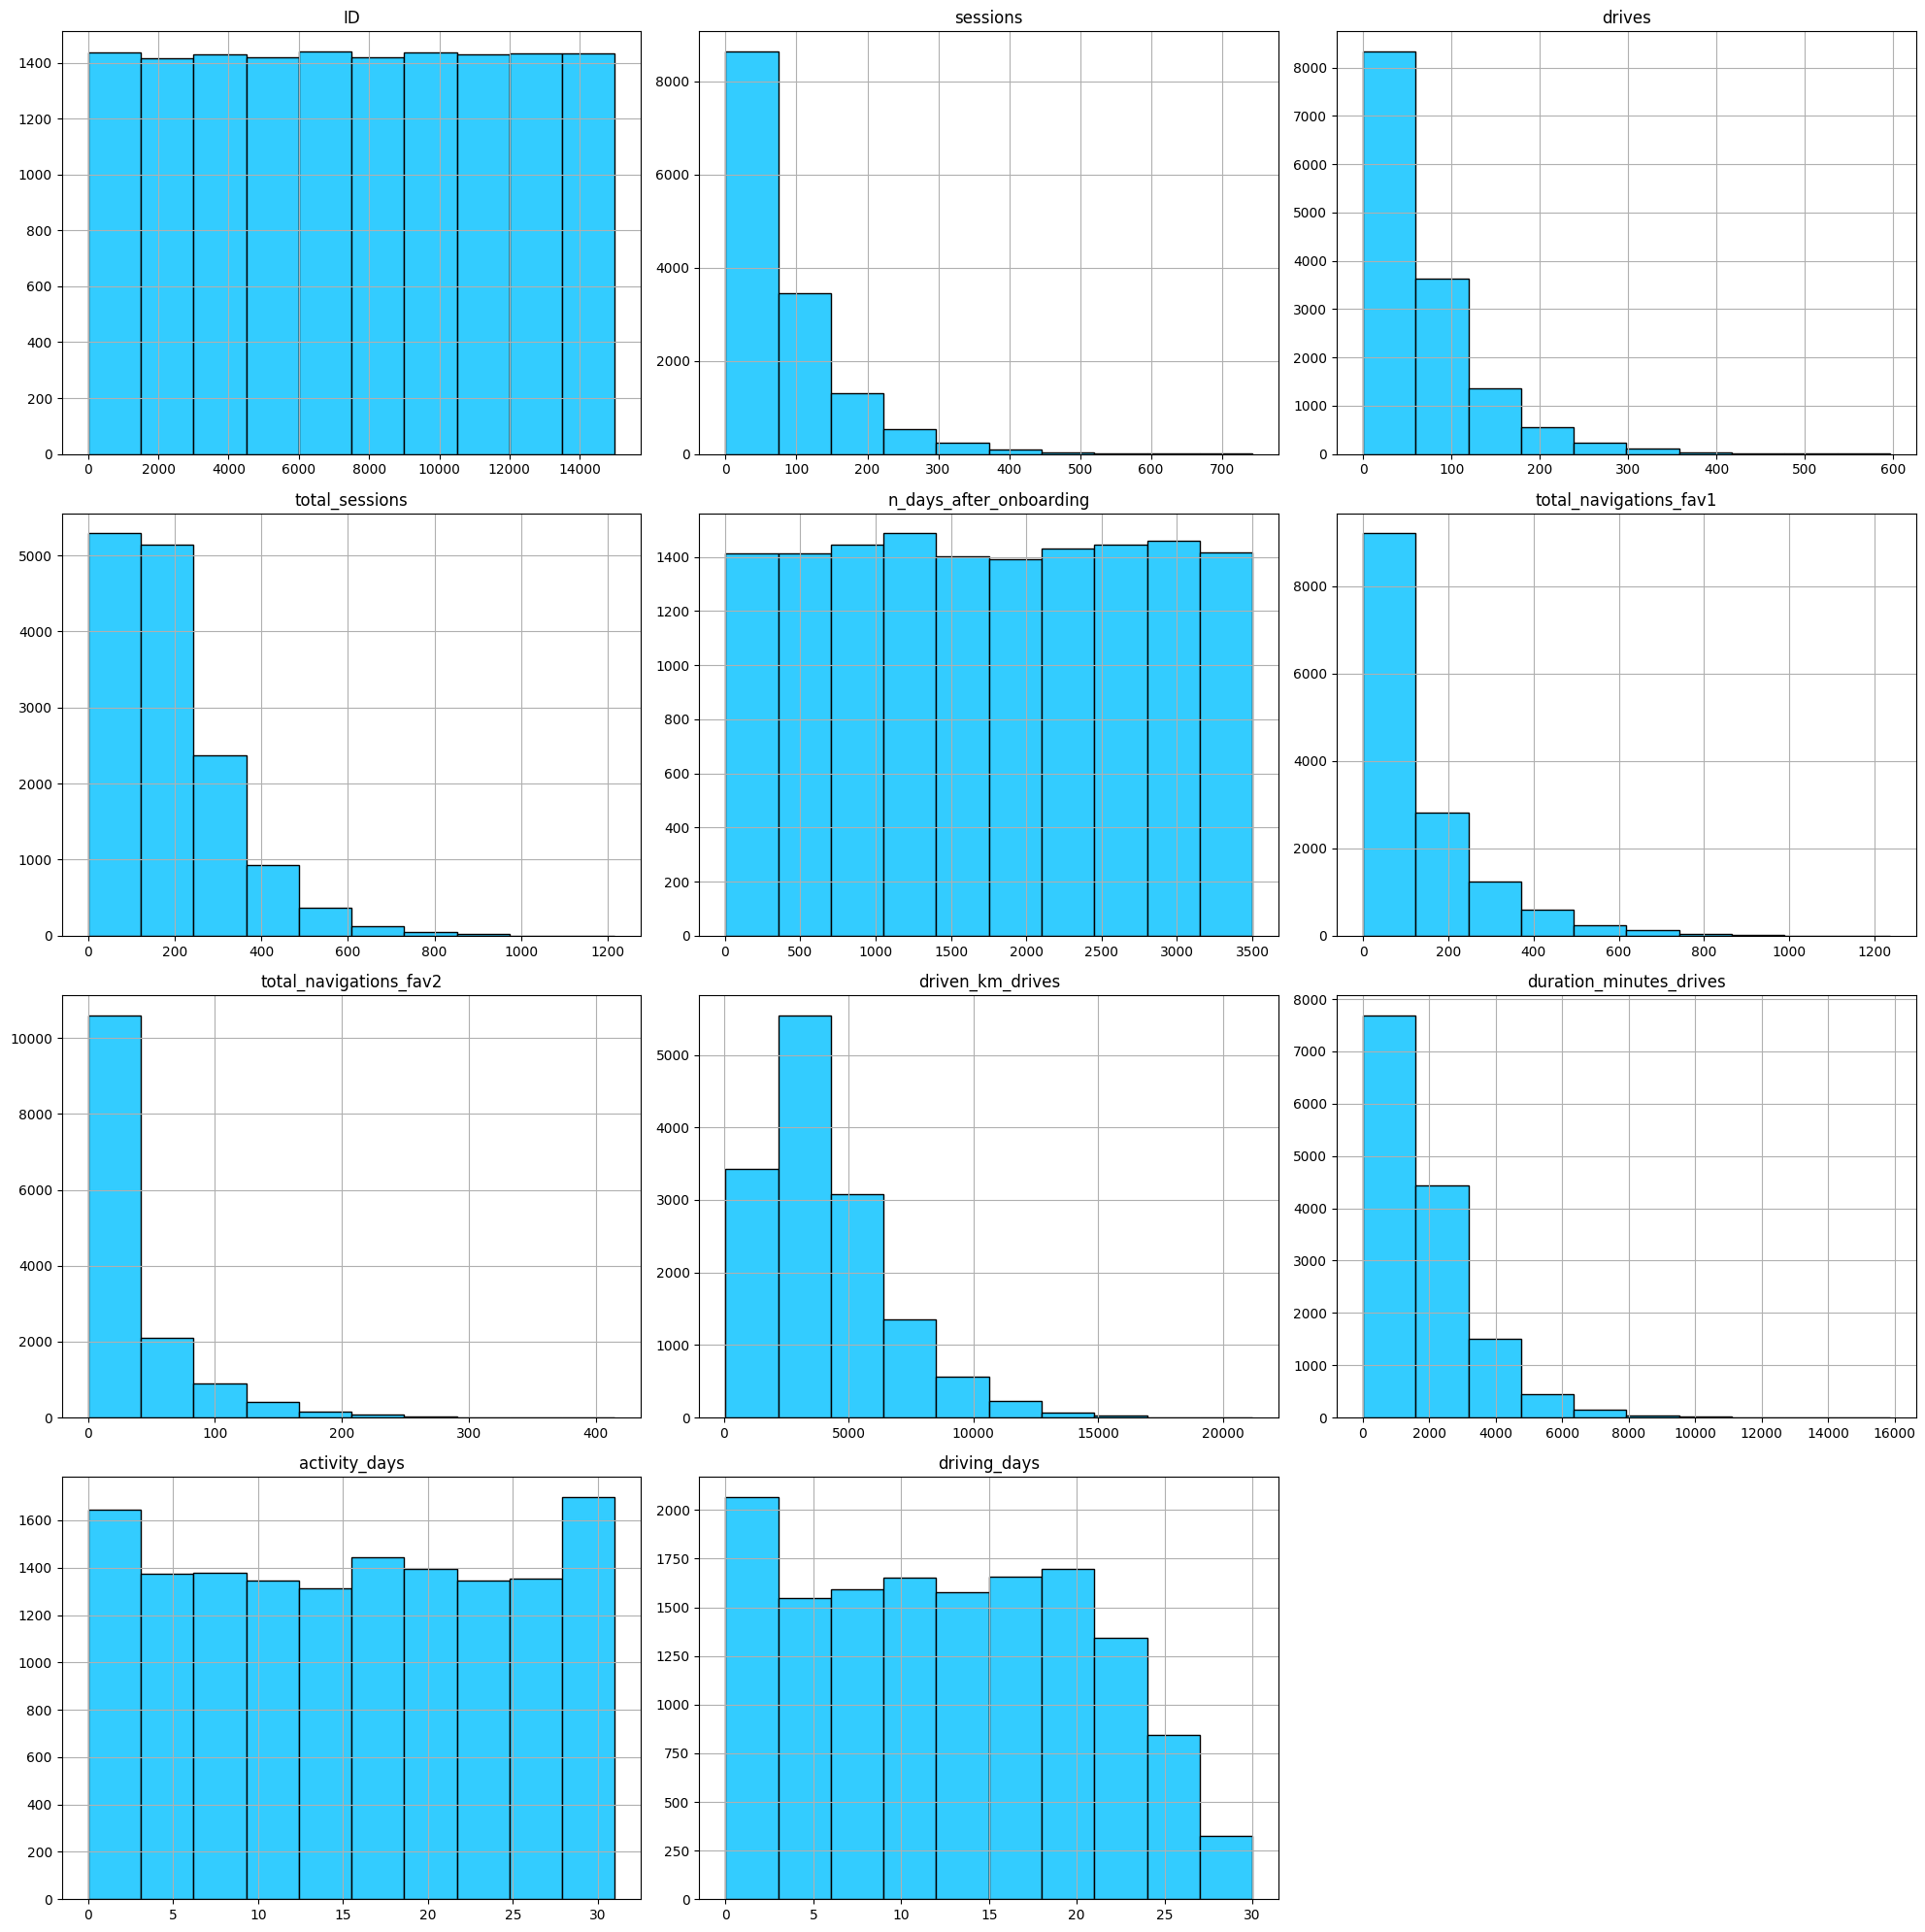

In [19]:
# Distribution of variables of cleaned data
data_numeric.hist(figsize=(20, 20), bins=10, color='#33CCFF', edgecolor='black')
plt.tight_layout()
plt.show()

**Insights**

n_days_after onboarding, activity_days and driving days seems to be nearly uniform while others are right skewed.

## Mapping the Exit: How Bad is User Churn?

<ipython-input-20-612b8e0acb3c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax= sns.countplot(x='label', data=data, palette=["#33CCFF", "#66CC66"])


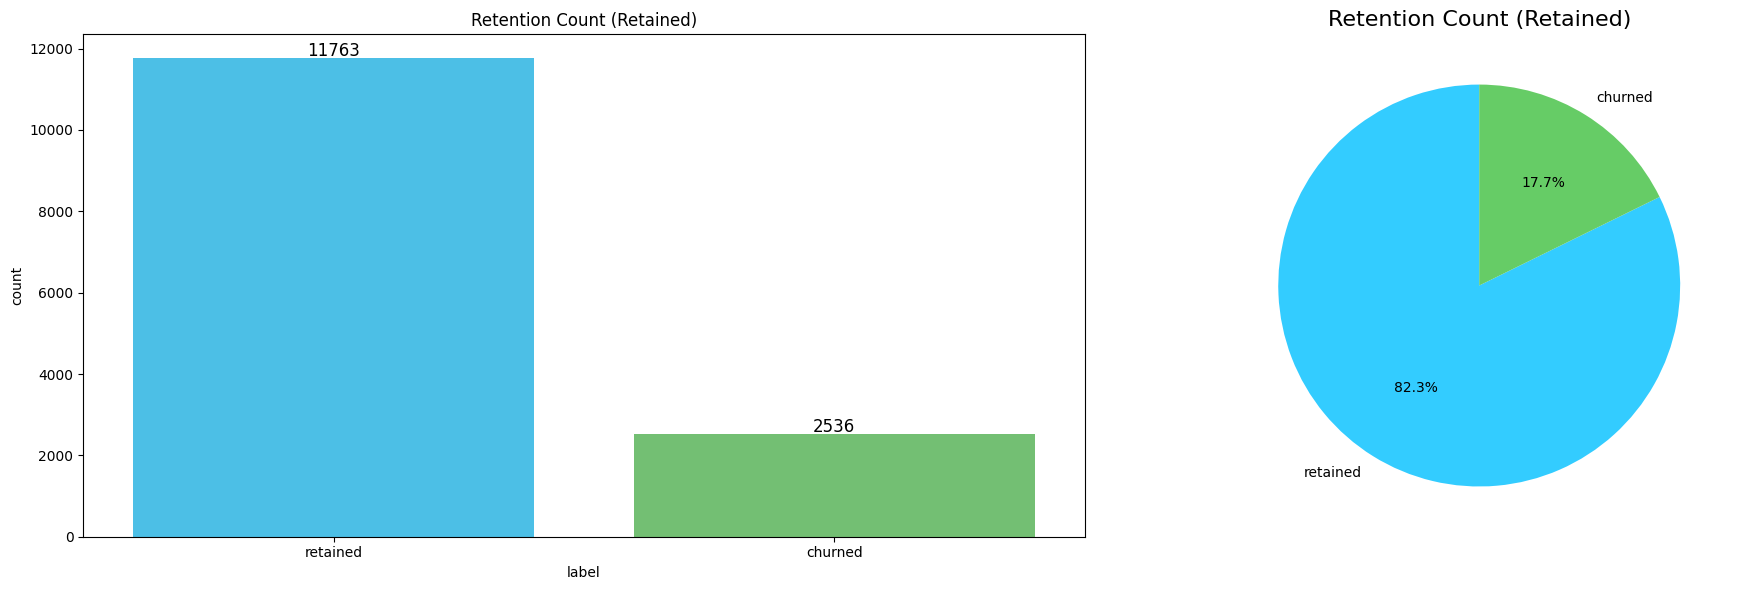

In [20]:

# PLOT- churn Vs Retention
plt.figure(figsize=(20, 6))

# Plot 1
plt.subplot(1, 2, 1)
ax= sns.countplot(x='label', data=data, palette=["#33CCFF", "#66CC66"])

# Add values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.title('Retention Count (Retained)')


# Plot 2:
plt.subplot(1, 2, 2)
# Count the occurrences of each label
label_counts = data['label'].value_counts()
# Plot the pie chart
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',colors=["#33CCFF", "#66CC66"], startangle=90)
plt.title('Retention Count (Retained)', fontsize=16)

plt.tight_layout()
plt.show()


**Insights**

About 82.3% of users retained (11763) and 17.7% of users churned (2536).

## We’ve Lost 17.71% of Our Users !

# Retained VS Churned

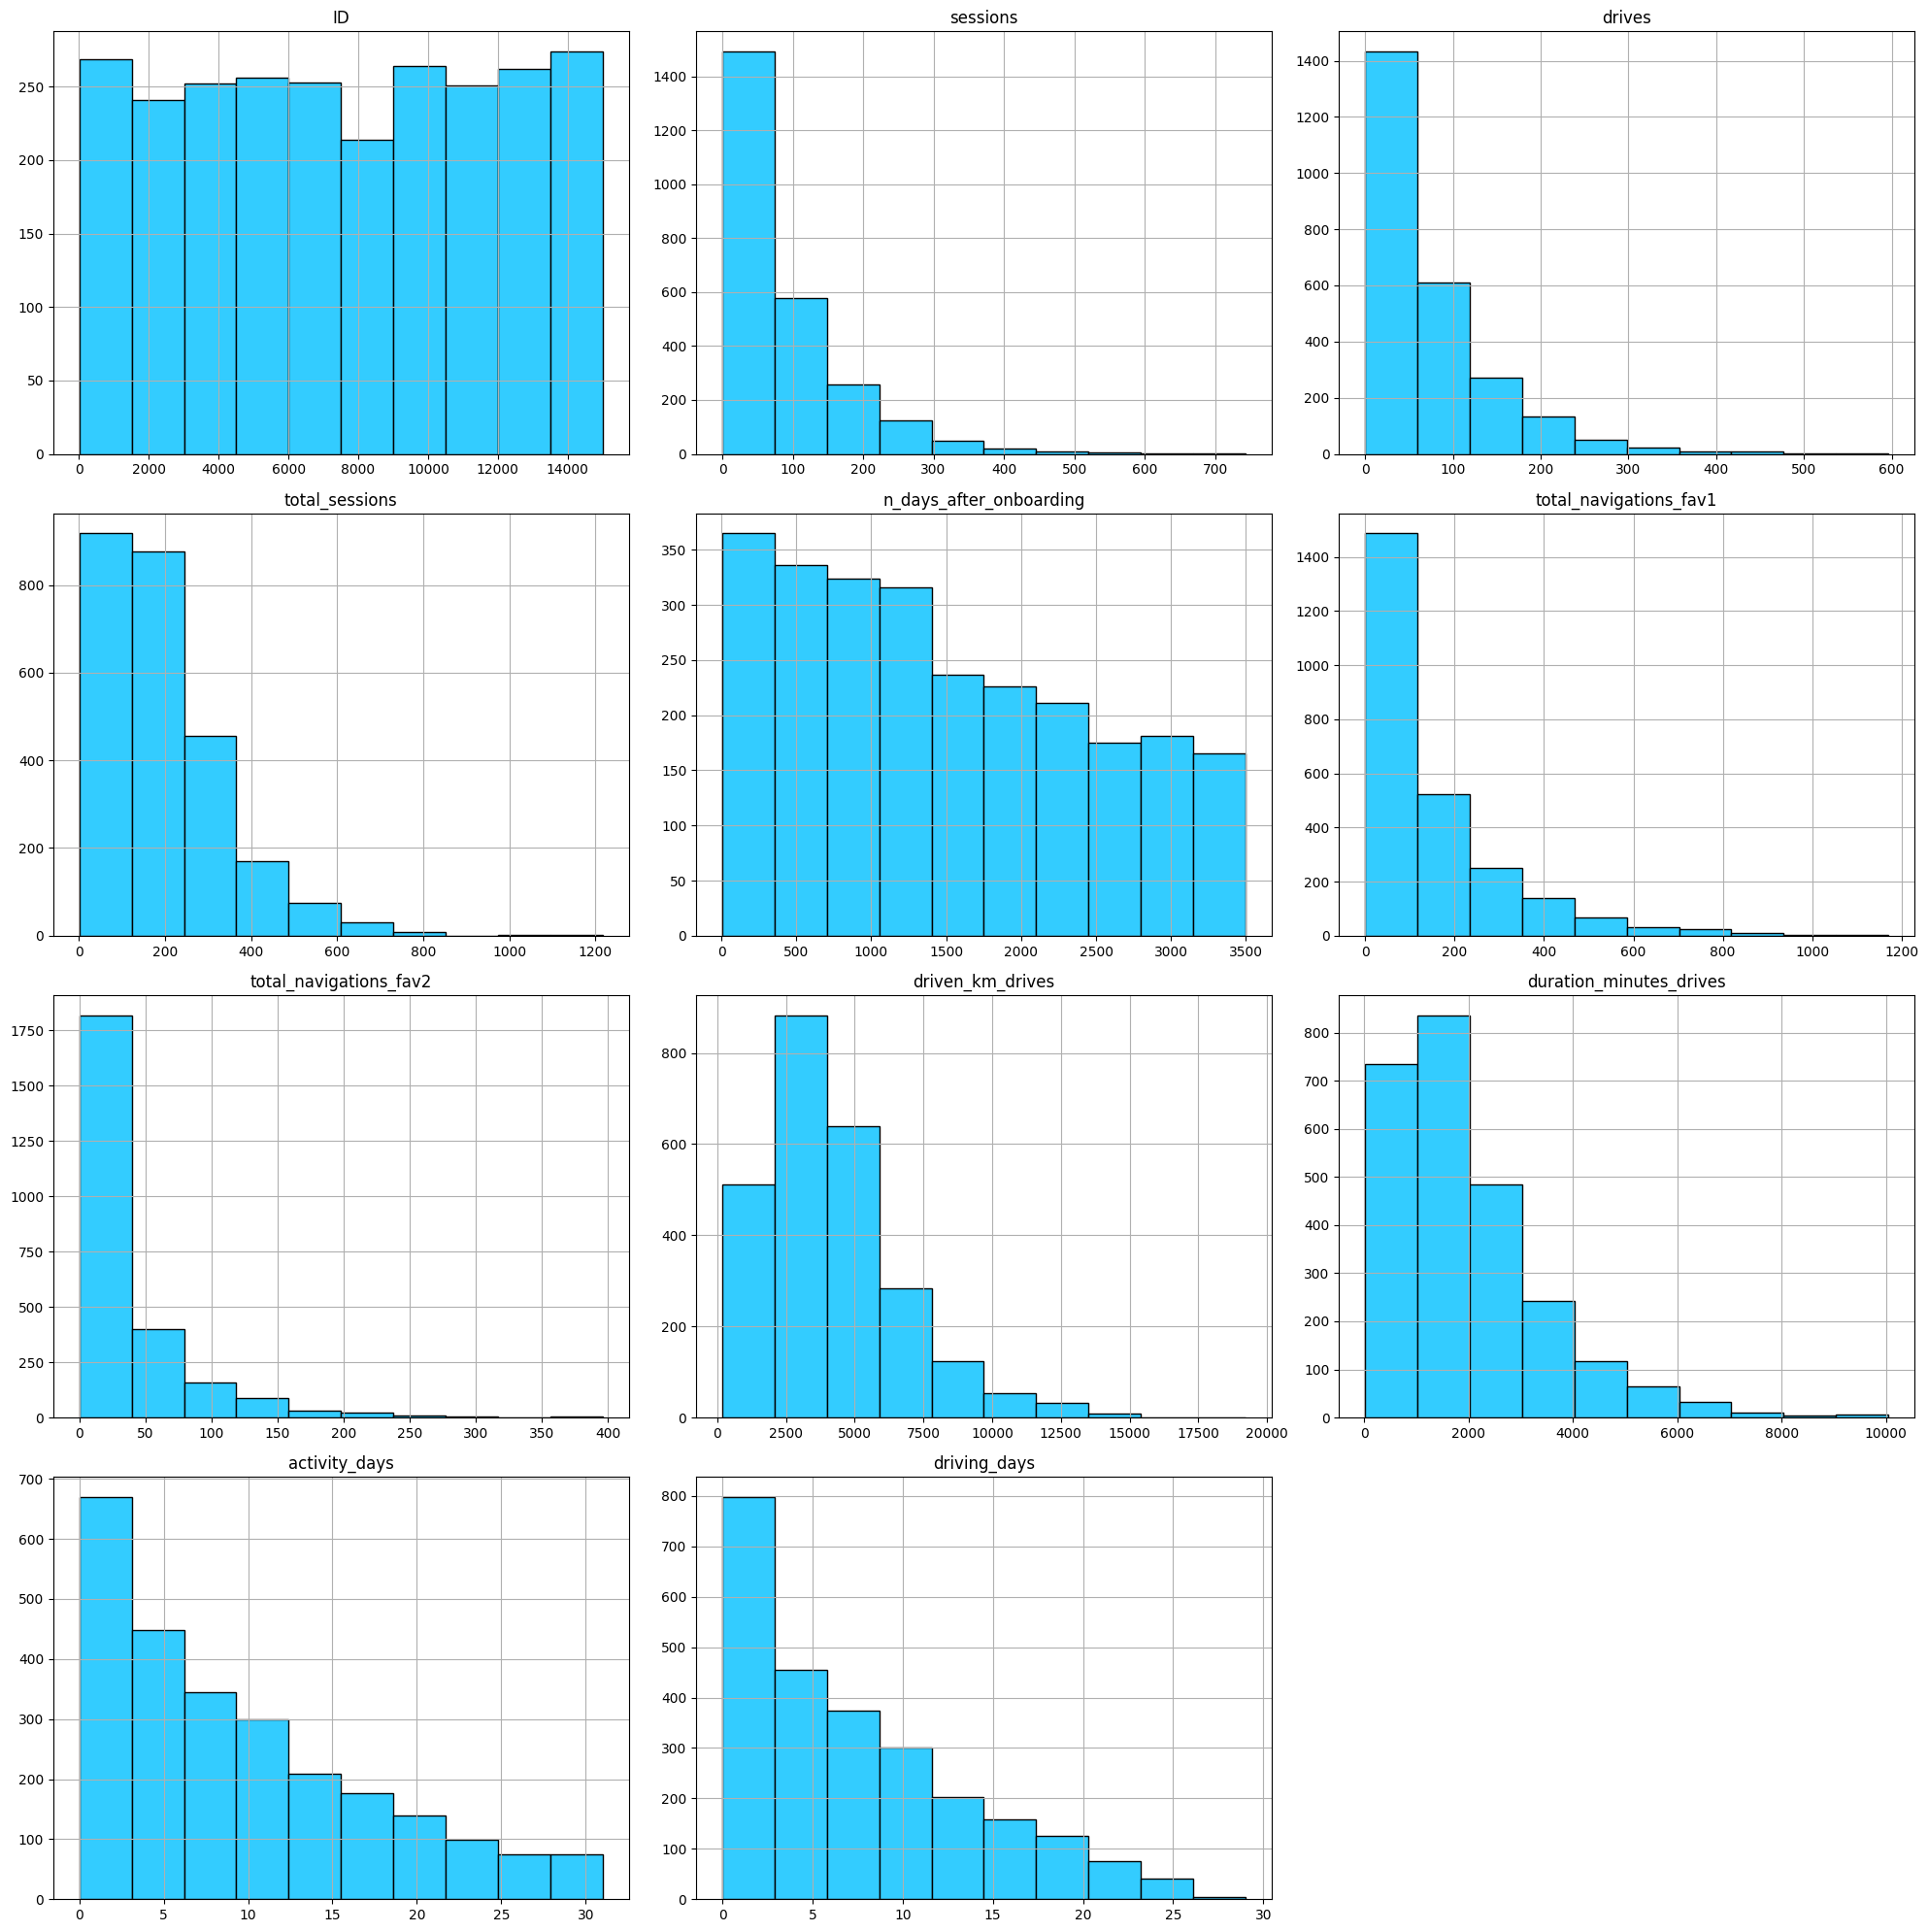

In [21]:
# Churned data distribution
data_numeric_churned = pd.DataFrame()

for column in data_churned.columns:

    if data_churned[column].dtypes == "int64" or data_churned[column].dtypes == "float64":
        data_numeric_churned[column] = data_churned[column]

data_numeric_churned.hist(figsize=(20, 20), bins=10, color="#33CCFF", edgecolor='black')
plt.tight_layout()
plt.show()


**Insights**

For churned users, except ID everything is right skewed. The features such as n_days_after_onboarding, activity_days and driving_days which were uniform in the data is now right skewed.

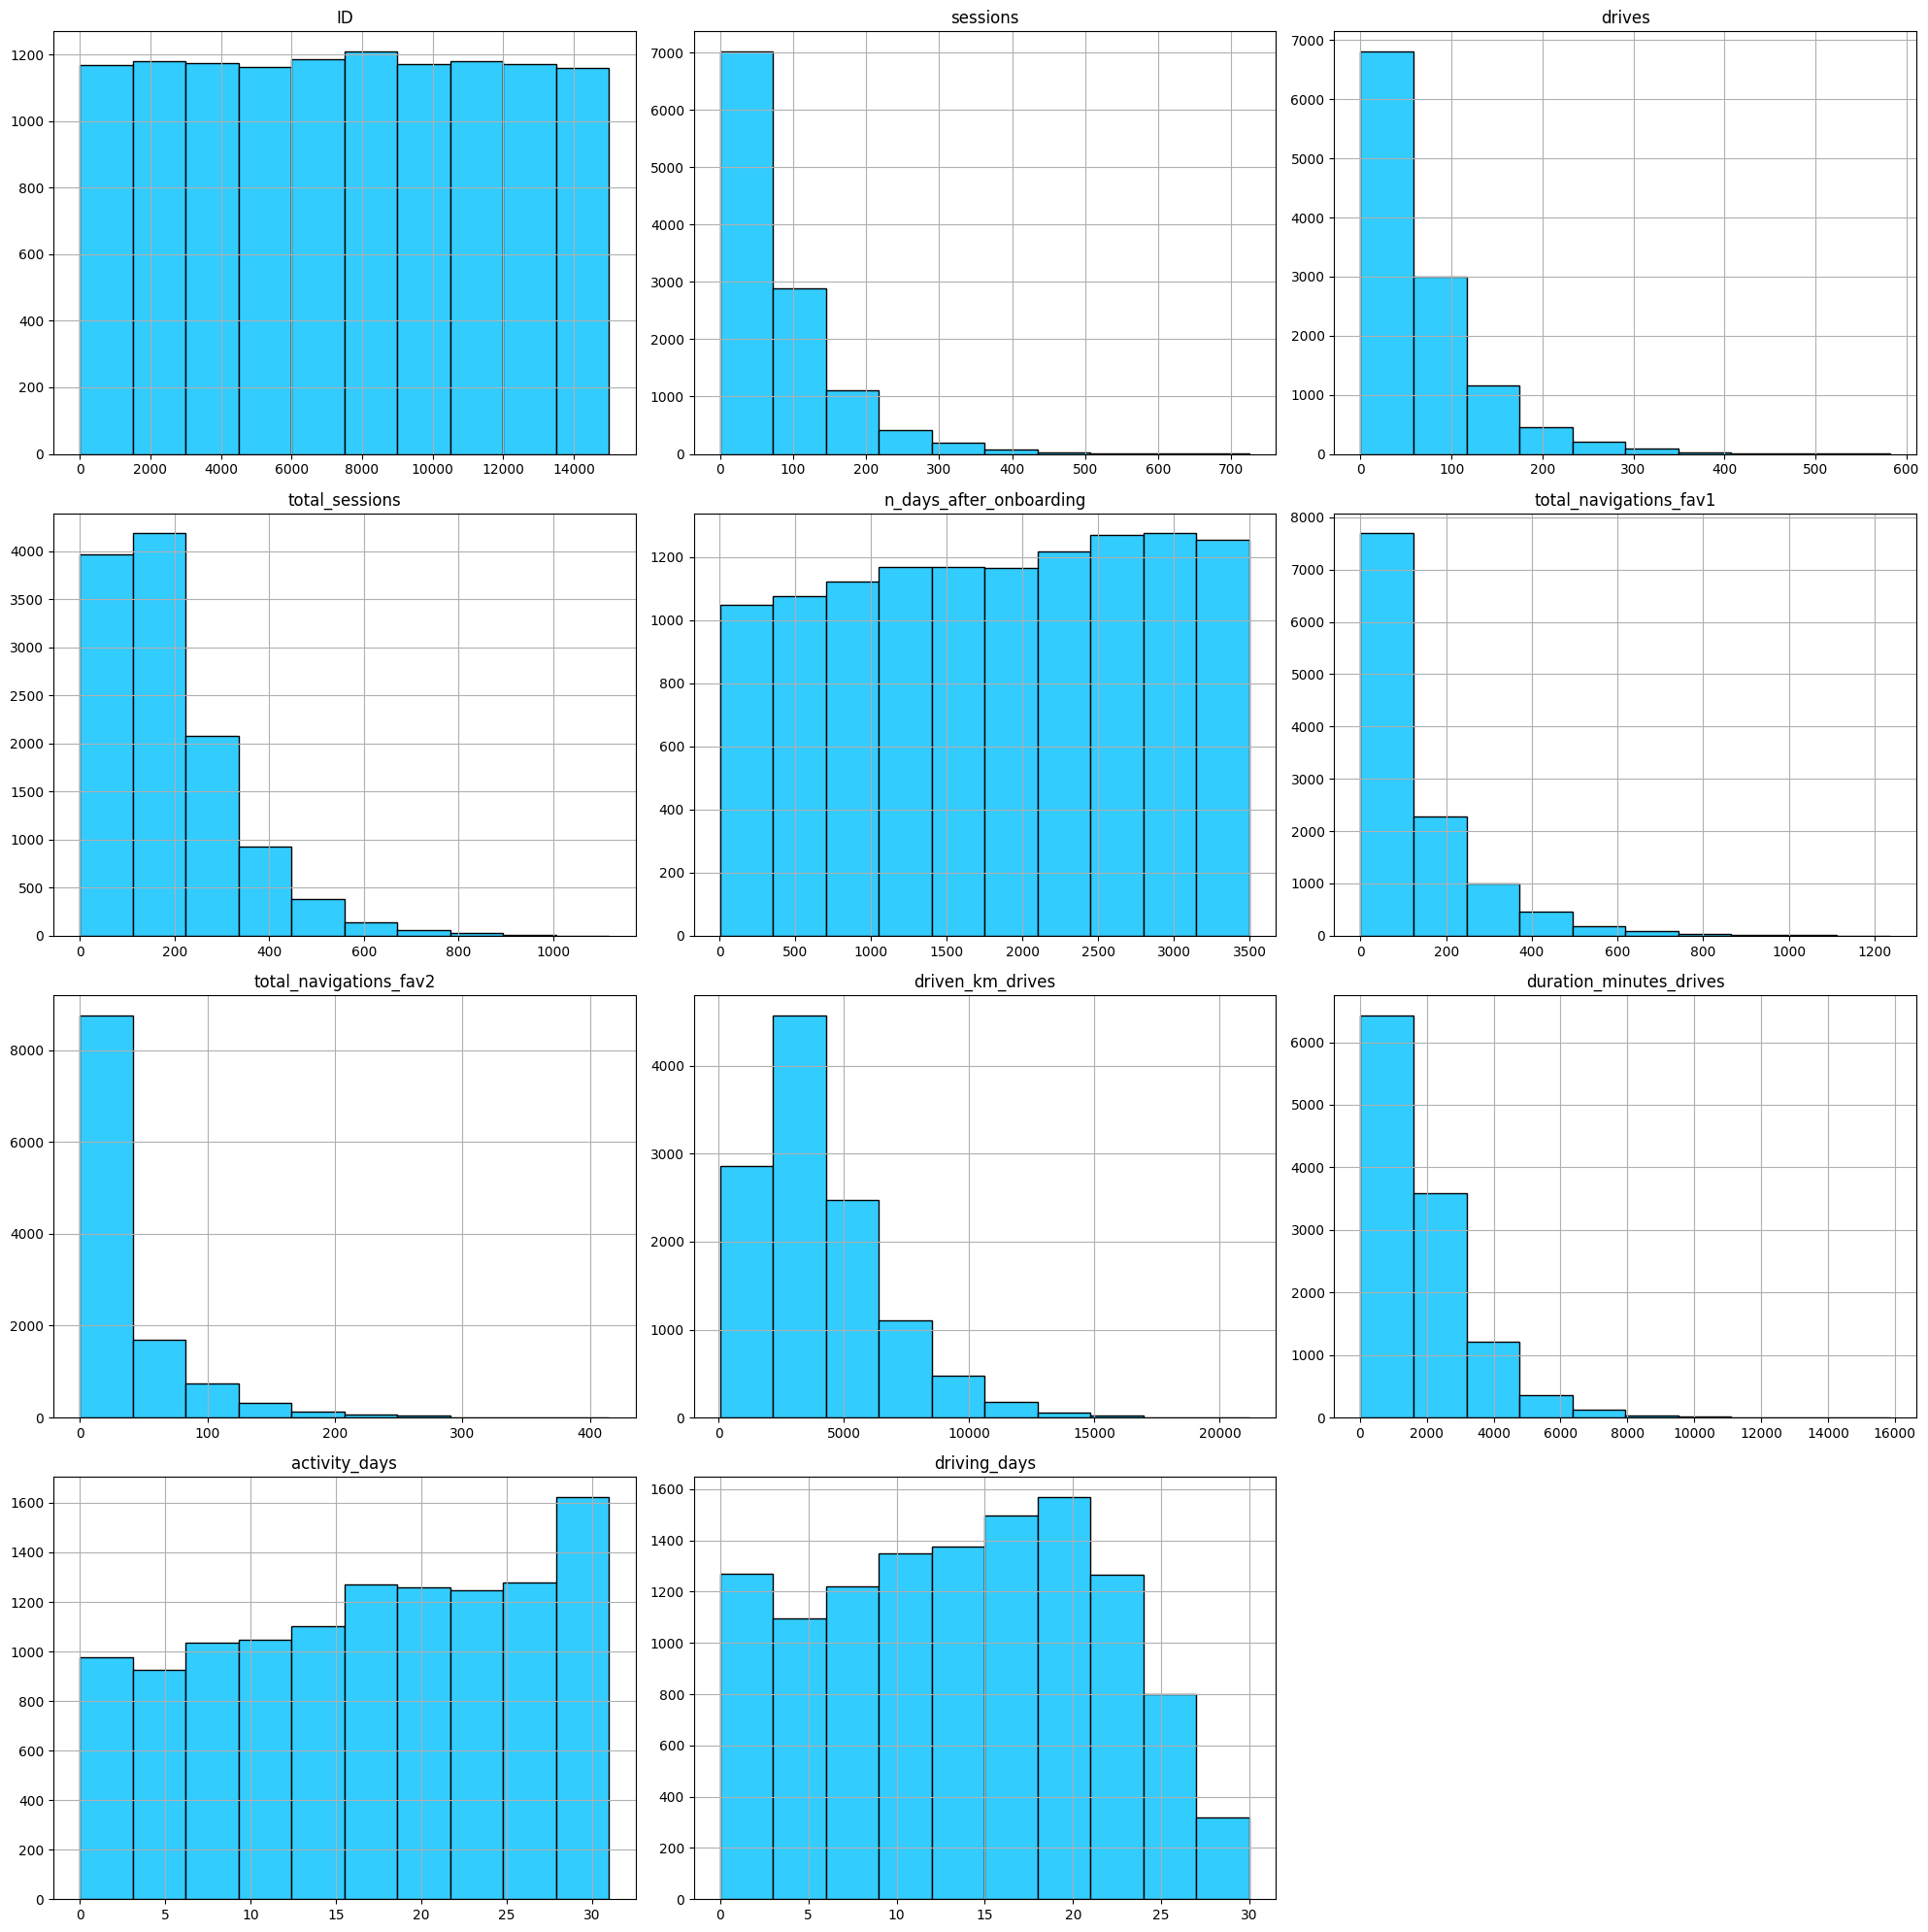

In [22]:
# data of retained
data_numeric_retained = pd.DataFrame()

for column in data_retained.columns:

    if data_retained[column].dtypes == "int64" or data_retained[column].dtypes == "float64":
        data_numeric_retained[column] = data_retained[column]

data_numeric_retained.hist(figsize=(20, 20), bins=10, color="#33CCFF", edgecolor='black')
plt.tight_layout()
plt.show()

**INSIGHTS**

In the case of retained customers, features such as n_days_after_onboarding, activity_days and driving days is different from the churned data. All of them are slightly left skewed

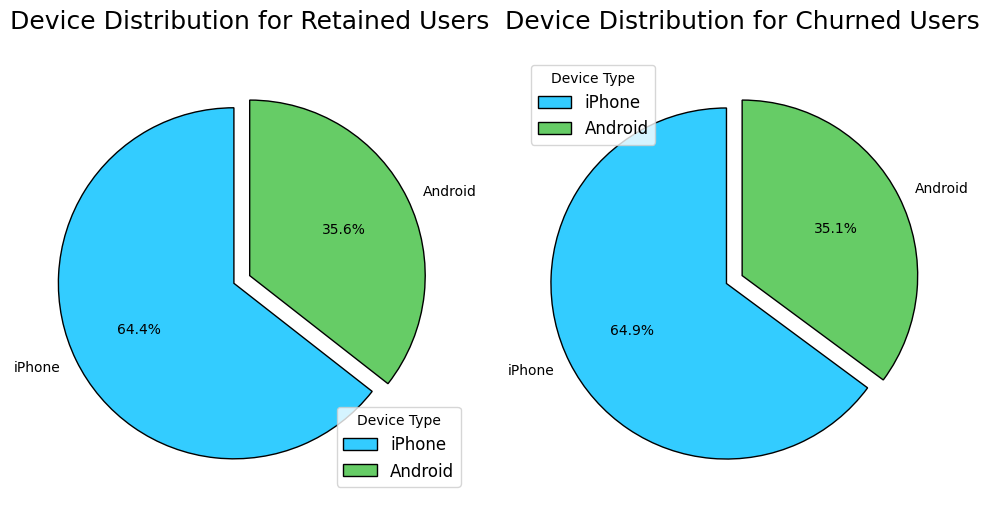

In [23]:

plt.figure(figsize=(10, 6))

# Plot 1:
plt.subplot(1, 2, 1)

# Count the occurrences of each device type in data_retained
device_counts_retained = data_retained["device"].value_counts()


explode_retained = (0.1, 0)
ax1 = device_counts_retained.plot.pie(autopct='%1.1f%%', colors=["#33CCFF", "#66CC66"],
                                      startangle=90, legend=False, figsize=(10, 6),
                                      wedgeprops={'edgecolor': 'black'}, explode=explode_retained)

plt.title("Device Distribution for Retained Users", fontsize=18, pad=20)
plt.ylabel('')
plt.legend(device_counts_retained.index, title="Device Type", fontsize=12)

# Plot 2:
plt.subplot(1, 2, 2)

# Count the occurrences of each device type in data_churned
device_counts_churned = data_churned["device"].value_counts()

explode_churned = (0.1, 0)
ax2 = device_counts_churned.plot.pie(autopct='%1.1f%%', colors=["#33CCFF", "#66CC66"],
                                      startangle=90, legend=False, figsize=(10, 6),
                                      wedgeprops={'edgecolor': 'black'}, explode=explode_churned)

plt.title("Device Distribution for Churned Users", fontsize=18, pad=20)
plt.ylabel('')
plt.legend(device_counts_churned.index, title="Device Type", fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()



# Insights
Type of device does not seem to be different for churned and retained users.

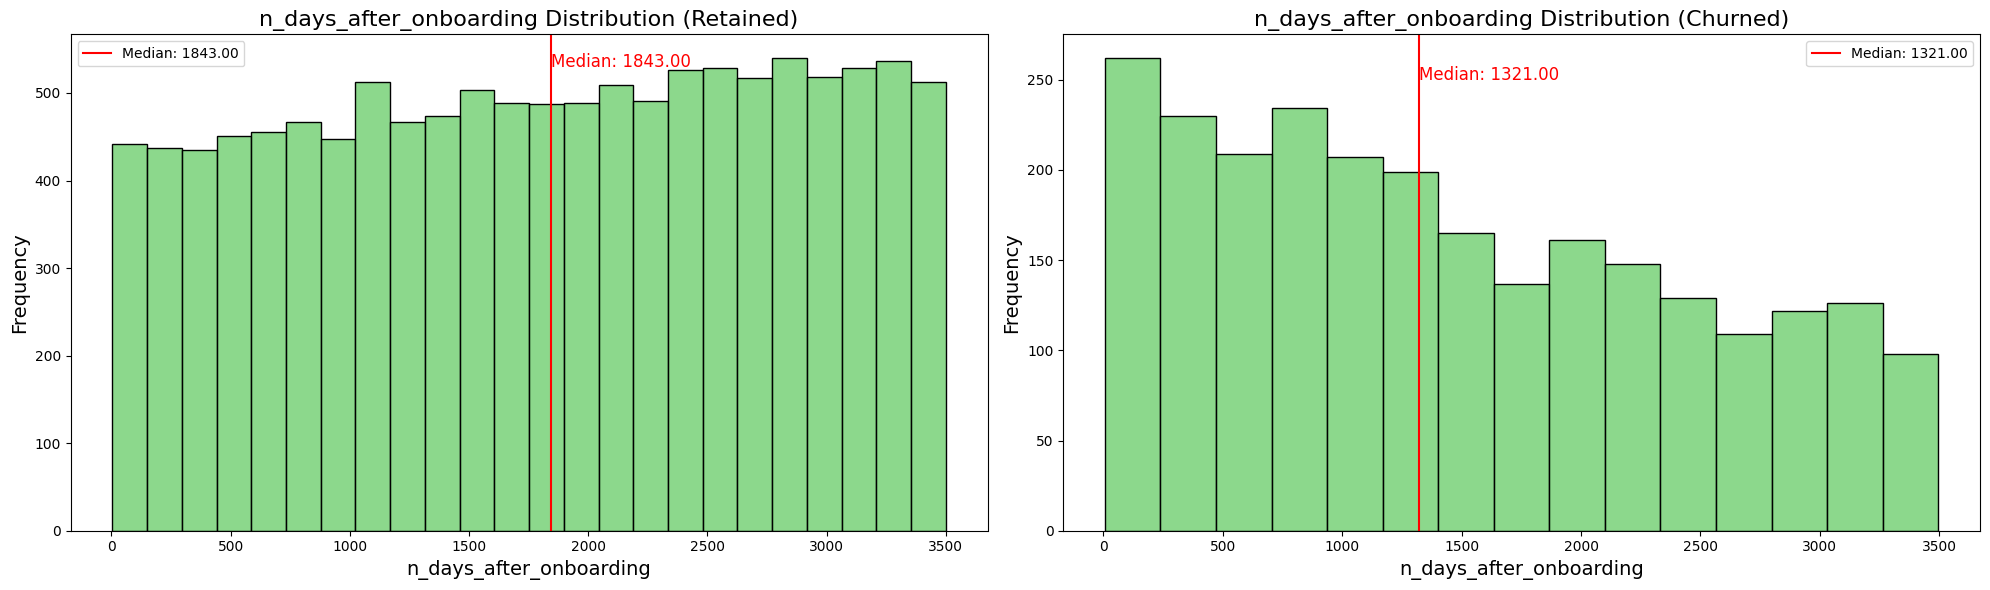

In [24]:

plt.figure(figsize=(20, 6))

# Plot 1:
plt.subplot(1, 2, 1)
median_value_retained = data_retained["n_days_after_onboarding"].median()
sns.histplot(data_retained["n_days_after_onboarding"],color="#66CC66")
plt.axvline(median_value_retained, color='red', linestyle='-', label=f'Median: {median_value_retained:.2f}')
plt.text(median_value_retained + 0.5, 530, f'Median: {median_value_retained:.2f}', color='red', fontsize=12)
plt.title("n_days_after_onboarding Distribution (Retained)", fontsize=16)
plt.xlabel("n_days_after_onboarding", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()

# Plot 2:
plt.subplot(1, 2, 2)
median_value_churned = data_churned["n_days_after_onboarding"].median()
sns.histplot(data_churned["n_days_after_onboarding"],color="#66CC66")
plt.axvline(median_value_churned, color='red', linestyle='-', label=f'Median: {median_value_churned:.2f}')
plt.text(median_value_churned + 0.5, 250, f'Median: {median_value_churned:.2f}', color='red', fontsize=12)
plt.title("n_days_after_onboarding Distribution (Churned)", fontsize=16)
plt.xlabel("n_days_after_onboarding", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

**Churn**

The distribution is skewed towards fewer days.
The median value is 1321 days, indicating that churned users tend to have a lower number of days after onboarding compared to retained users, with a noticeable drop-off after a certain point.

**Retention vs. Churn**:

Users who have been onboarded for a longer period (closer to the median of 1843 days) are more likely to remain retained, while churned users tend to have a shorter period after onboarding (around 1321 days on average). This could suggest that retaining users for a longer period is key to reducing churn.

## Who’s in the Driver’s Seat? Exploring Waze’s Customer Base

# Segment Our Customers

In [25]:
min(data["n_days_after_onboarding"])

4

In [26]:
max(data["n_days_after_onboarding"])

3500

In [27]:
3500-4/5

3499.2

In [28]:
data_segmented=pd.DataFrame(data)
# Define the bins and labels for segmentation
bins = [0, 30, 180, 365,1825, 3501]  # 1 month, 1 month to 6 months,6 months to 1 year,1 year to 5 years,5 years to approximately 9.5 years
labels = ['new_users', 'active_users', 'mature_users', 'long_term_users','very_long_term_users']

data_retained.loc[:, 'days_segment'] = pd.cut(data_retained['n_days_after_onboarding'], bins=bins, labels=labels, right=False)
data_churned.loc[:, 'days_segment'] = pd.cut(data_churned['n_days_after_onboarding'], bins=bins, labels=labels, right=False)
data_segmented.loc[:, 'days_segment'] = pd.cut(data['n_days_after_onboarding'], bins=bins, labels=labels, right=False)


data_segmented.to_csv("data_segmented.csv")



<ipython-input-28-5e6e11cf77d9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_retained.loc[:, 'days_segment'] = pd.cut(data_retained['n_days_after_onboarding'], bins=bins, labels=labels, right=False)
<ipython-input-28-5e6e11cf77d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_churned.loc[:, 'days_segment'] = pd.cut(data_churned['n_days_after_onboarding'], bins=bins, labels=labels, right=False)


In [29]:
data_segmented[data_segmented.isnull().any(axis=1)]


,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,days_segment


In [30]:
print(data_retained['days_segment'].value_counts())

days_segment
very_long_term_users    5940
long_term_users         4739
mature_users             545
active_users             457
new_users                 82
Name: count, dtype: int64


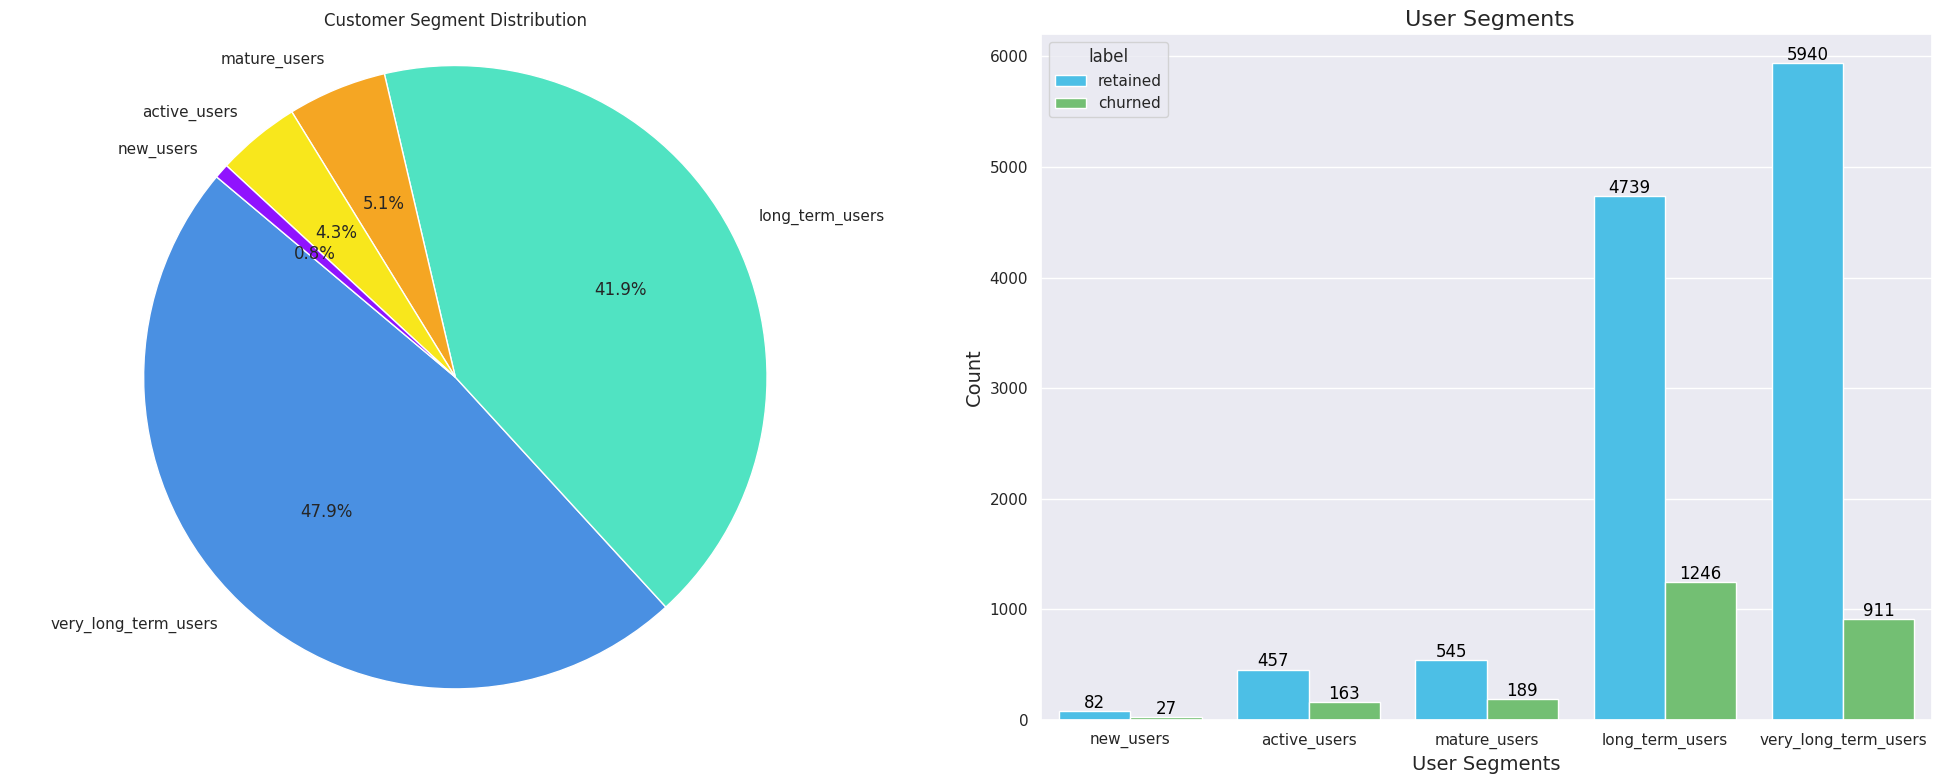

In [96]:
plt.figure(figsize=(20, 8))

# Plot 1
plt.subplot(1, 2, 1)
segment_counts = data_segmented['days_segment'].value_counts()
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors = ['#4A90E2',
          '#50E3C2',
          '#F5A623',
          '#F8E71C',
          '#9013FE']  )
plt.title('Customer Segment Distribution')
plt.axis('equal')

# Plot 2:
plt.subplot(1, 2, 2)
ax = sns.countplot(x='days_segment', hue='label', data=data_segmented, palette=["#33CCFF", "#66CC66"])

# values
for p in ax.patches:
    value = int(p.get_height())
    if value > 0:
        ax.annotate(f'{value}',
                    (p.get_x() + p.get_width() / 2., p.get_height() + 10),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title(' User Segments', fontsize=16)
plt.xlabel('User Segments', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.ylim(0, 6200)


plt.tight_layout()
plt.show()

## A Loyal Base, But Where Are the New Users?

# Insights

Most of our user base is dominated by very_long_term_users(5 years to approximately 9.5 years) 47.9%, then comes long_term_users(1 year to 5 years) of 41.9%. The new_users(0-1 month) only comprise 0.8%.

What Can We Do?

Simplify Onboarding: Provide clear tutorials or step-by-step navigation.

Gamify Onboarding: Offer rewards for completing setup and first reports.

Welcome Campaigns: Use personalized notifications and email follow-ups.

Partner Promotions: Collaborate with businesses to attract first-time users.

## Who’s Taken the Exit? Understanding Our Lost Users

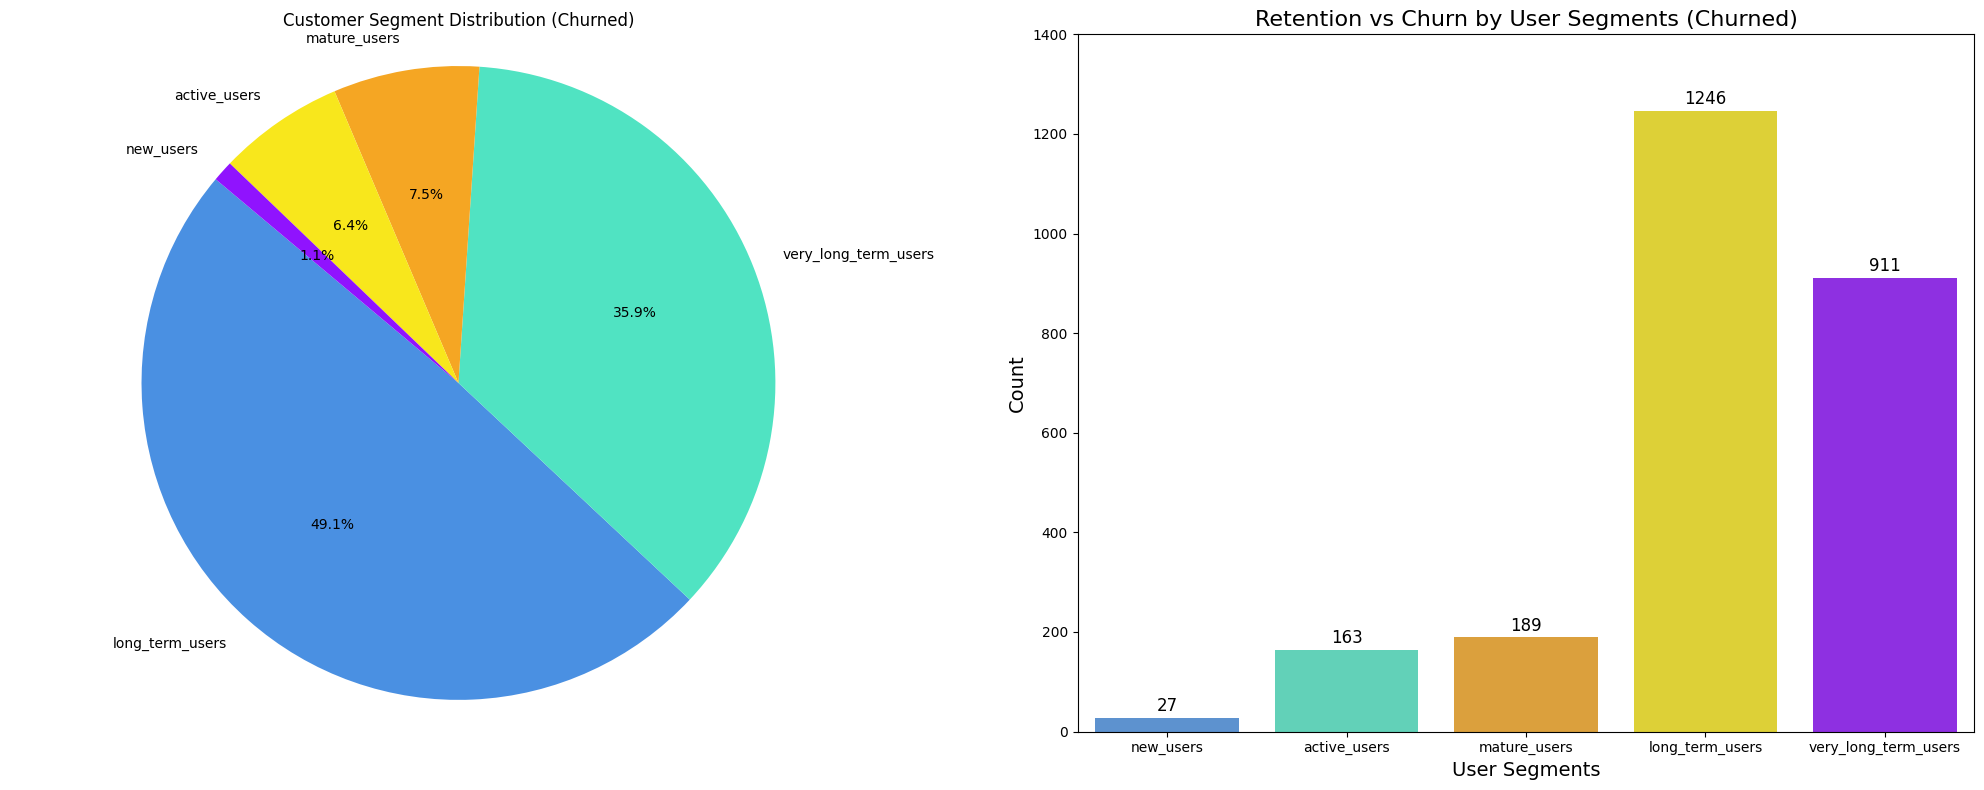

In [32]:
plt.figure(figsize=(20, 8))

# Plot 1:
plt.subplot(1, 2, 1)
segment_counts = data_churned['days_segment'].value_counts()
# Plotting the pie chart
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors = ['#4A90E2',
          '#50E3C2',
          '#F5A623',
          '#F8E71C',
          '#9013FE'] )
plt.title('Customer Segment Distribution (Churned)')
plt.axis('equal')

# Plot 2:
plt.subplot(1, 2, 2)
ax = sns.countplot(x='days_segment', hue='days_segment', data=data_churned, palette= ['#4A90E2',
          '#50E3C2',
          '#F5A623',
          '#F8E71C',
          '#9013FE'] )

# Display values
for p in ax.patches:
    value = int(p.get_height())
    if value > 0:
        ax.annotate(f'{value}',
                    (p.get_x() + p.get_width() / 2., p.get_height() + 10),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Retention vs Churn by User Segments (Churned)', fontsize=16)
plt.xlabel('User Segments', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.ylim(0, 1400)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Losing Our Foundation: A Deep Dive into Churn Among Long-Term Users

The users who churned the most are long_term_users 49.1% and then very_long_term_users at 35.9%. These were our dominant customer base, and we are losing them.


---


What can we do?

**Re-Engagement Strategies:**



Personalized win-back campaigns targeting churned users.

Highlight new features or fixes to address past pain points.

Offer exclusive incentives for reactivation.

**Retention Strategies for Remaining Users:**



Invest in user experience improvements.

Gather feedback to understand unmet needs.

---





**1. Gamification and Rewards**

Encourage user contributions:(badges, levels or achievements)
Leaderboard

**Personalized Experience**

Customizable routes:Allow users to personalize their route preferences (e.g., scenic routes, avoiding tolls, etc.) and provide predictive navigation based on their typical driving patterns.

Driver profiles: Use data on user behavior to create tailored recommendations for routes, avoiding congestion, or suggesting alternative routes for their daily commute.

** Engagement with Real-Time Data**

Traffic and event updates:Real-time notifications about road conditions, accidents, or road closures can help users save time.

Local community engagement: Allow users to connect with other drivers in their area for updates on events, road conditions, and shared traffic insights.

**Reward for Consistent Use**

Mileage-based rewards: Reward users for consistent usage, like accumulating miles or hours driven using Waze. Offering incentives such as discounts or deals from partner companies (e.g., fuel discounts, local businesses, or car-related services) could increase retention.

Exclusive Features: Provide long-term users with exclusive features, such as early access to new features or premium navigation options for free.

**Incorporate Value-Added Services**

Safety Alerts

Fuel Price Alerts: Continue providing features like finding the cheapest gas stations nearby, which adds practical value and encourages users to keep using the app.


**Social Sharing & Collaboration**

Carpooling options

Group driving and road trips

**Consistency & Reliability**

App performance:fast updates and bug fixes.

Offline functionality

**Feedback and In-App Surveys**

Continuous feedback loop

Beta testing

**Partnerships and Collaborations**

Collaborate with local businesses: Develop partnerships with businesses (e.g., restaurants, hotels, or event venues) and offer exclusive deals to Waze users who frequent those locations. This could create a practical reason to keep using the app.

**Regular Updates and Communication**

App feature updates

Engage users with content: Send periodic notifications about new updates, tips for using the app, or fun facts to keep users engaged

In [33]:
data_churned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2536 entries, 9 to 14997
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ID                       2536 non-null   int64   
 1   label                    2536 non-null   object  
 2   sessions                 2536 non-null   int64   
 3   drives                   2536 non-null   int64   
 4   total_sessions           2536 non-null   float64 
 5   n_days_after_onboarding  2536 non-null   int64   
 6   total_navigations_fav1   2536 non-null   int64   
 7   total_navigations_fav2   2536 non-null   int64   
 8   driven_km_drives         2536 non-null   float64 
 9   duration_minutes_drives  2536 non-null   float64 
 10  activity_days            2536 non-null   int64   
 11  driving_days             2536 non-null   int64   
 12  device                   2536 non-null   object  
 13  days_segment             2536 non-null   category
dtypes: category(

In [34]:
data_churned['days_segment'].unique()

['very_long_term_users', 'active_users', 'long_term_users', 'mature_users', 'new_users']
Categories (5, object): ['new_users' < 'active_users' < 'mature_users' < 'long_term_users' <
                         'very_long_term_users']

## Driving Less, Using Less: Spotting Early Warning Signs of Churn

# Long Term Users

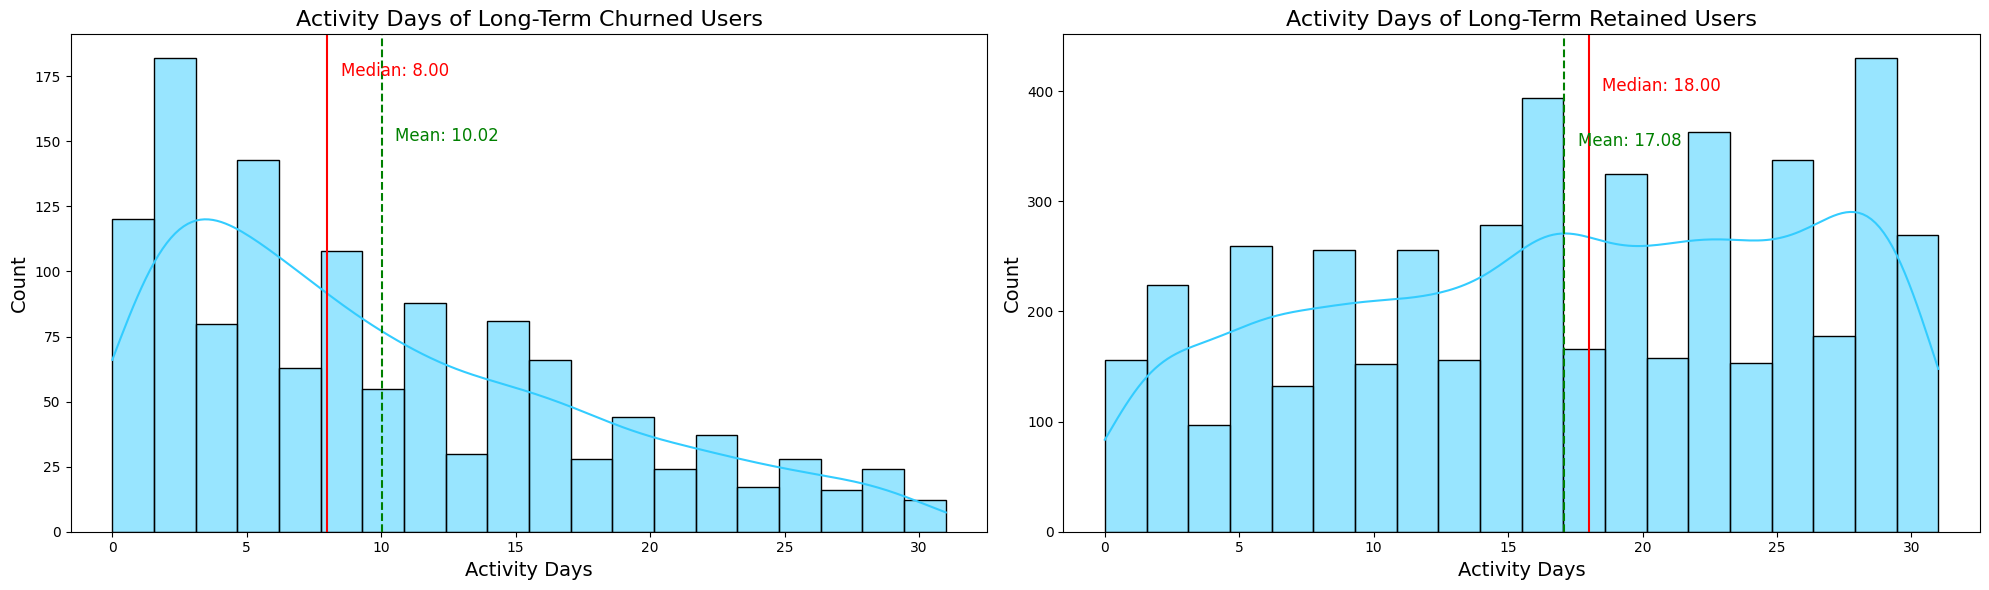

In [35]:
plt.figure(figsize=(20, 6))

# Plot 1
plt.subplot(1, 2, 1)
long_term_users_churned = data_churned[data_churned['days_segment'] == "long_term_users"]

sns.histplot(long_term_users_churned['activity_days'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for churned users
median_value_churned = long_term_users_churned['activity_days'].median()
mean_value_churned = long_term_users_churned['activity_days'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_churned, color='red', linestyle='-', label=f'Median: {median_value_churned:.2f}')
plt.axvline(mean_value_churned, color='green', linestyle='--', label=f'Mean: {mean_value_churned:.2f}')
plt.text(median_value_churned + 0.5, 175, f'Median: {median_value_churned:.2f}', color='red', fontsize=12)
plt.text(mean_value_churned + 0.5, 150, f'Mean: {mean_value_churned:.2f}', color='green', fontsize=12)

plt.title('Activity Days of Long-Term Churned Users', fontsize=16)
plt.xlabel('Activity Days', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Plot 2
plt.subplot(1, 2, 2)
long_term_users_retained = data_retained[data_retained['days_segment'] == "long_term_users"]

# Plot histogram for activity days of long-term users who retained
sns.histplot(long_term_users_retained['activity_days'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for retained users
median_value_retained = long_term_users_retained['activity_days'].median()
mean_value_retained = long_term_users_retained['activity_days'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_retained, color='red', linestyle='-', label=f'Median: {median_value_retained:.2f}')
plt.axvline(mean_value_retained, color='green', linestyle='--', label=f'Mean: {mean_value_retained:.2f}')
plt.text(median_value_retained + 0.5, 400, f'Median: {median_value_retained:.2f}', color='red', fontsize=12)
plt.text(mean_value_retained + 0.5, 350, f'Mean: {mean_value_retained:.2f}', color='green', fontsize=12)

plt.title('Activity Days of Long-Term Retained Users', fontsize=16)
plt.xlabel('Activity Days', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.tight_layout()
plt.show()


## Low Activity, High Risk: Understanding Churn Drivers

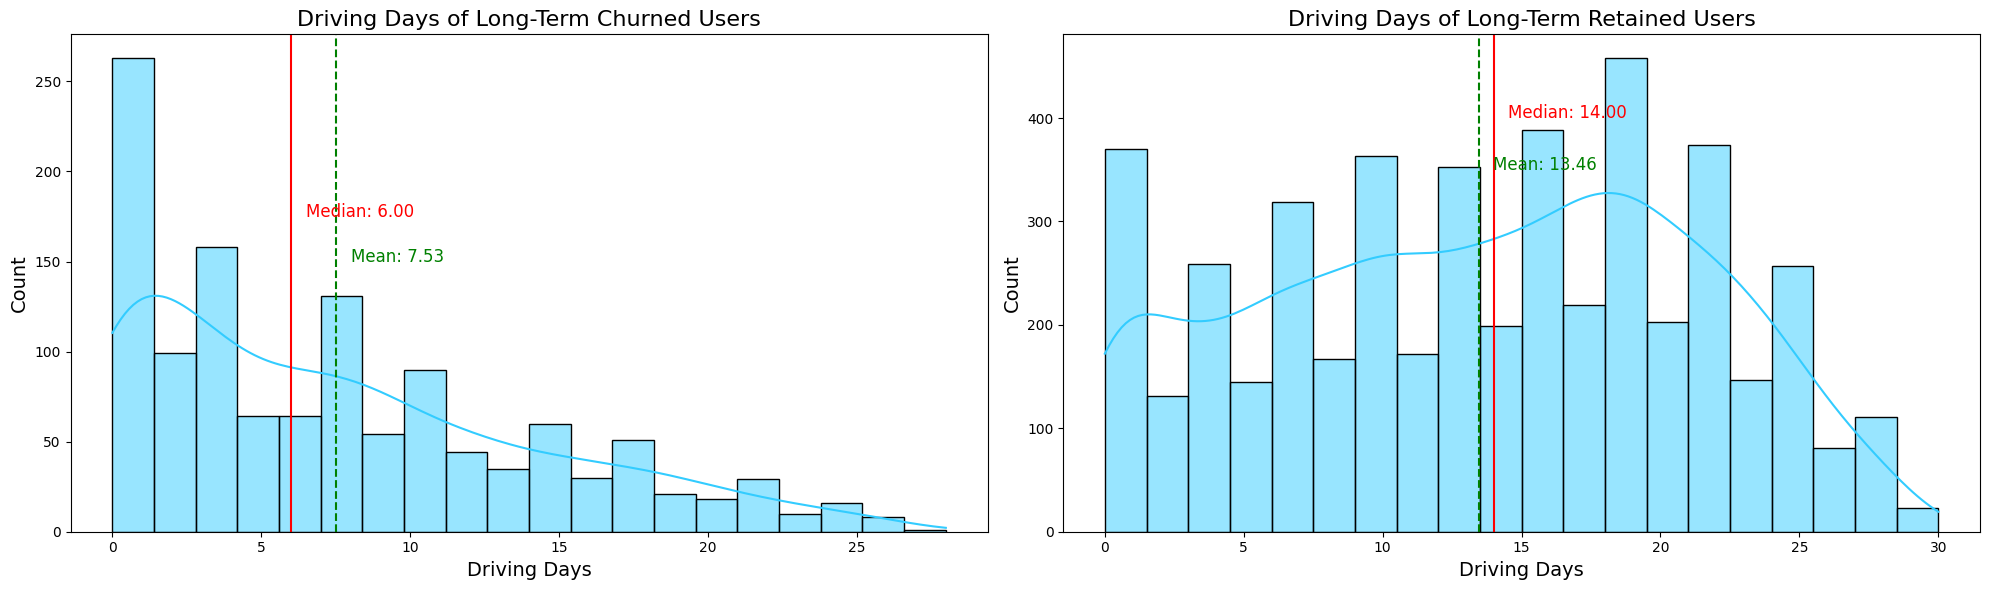

In [36]:
plt.figure(figsize=(20, 6))

# Plot 1:
plt.subplot(1, 2, 1)

sns.histplot(long_term_users_churned['driving_days'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for churned users
median_value_churned = long_term_users_churned['driving_days'].median()
mean_value_churned = long_term_users_churned['driving_days'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_churned, color='red', linestyle='-', label=f'Median: {median_value_churned:.2f}')
plt.axvline(mean_value_churned, color='green', linestyle='--', label=f'Mean: {mean_value_churned:.2f}')
plt.text(median_value_churned + 0.5, 175, f'Median: {median_value_churned:.2f}', color='red', fontsize=12)
plt.text(mean_value_churned + 0.5, 150, f'Mean: {mean_value_churned:.2f}', color='green', fontsize=12)

plt.title('Driving Days of Long-Term Churned Users', fontsize=16)
plt.xlabel('Driving Days', fontsize=14)
plt.ylabel('Count', fontsize=14)



# Plot 2:
plt.subplot(1, 2, 2)
sns.histplot(long_term_users_retained['driving_days'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for retained users
median_value_retained = long_term_users_retained['driving_days'].median()
mean_value_retained = long_term_users_retained['driving_days'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_retained, color='red', linestyle='-', label=f'Median: {median_value_retained:.2f}')
plt.axvline(mean_value_retained, color='green', linestyle='--', label=f'Mean: {mean_value_retained:.2f}')
plt.text(median_value_retained + 0.5, 400, f'Median: {median_value_retained:.2f}', color='red', fontsize=12)
plt.text(mean_value_retained + 0.5, 350, f'Mean: {mean_value_retained:.2f}', color='green', fontsize=12)

plt.title('Driving Days of Long-Term Retained Users', fontsize=16)
plt.xlabel('Driving Days', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.tight_layout()
plt.show()


## Driving Less, Leaving More: The Churn Connection

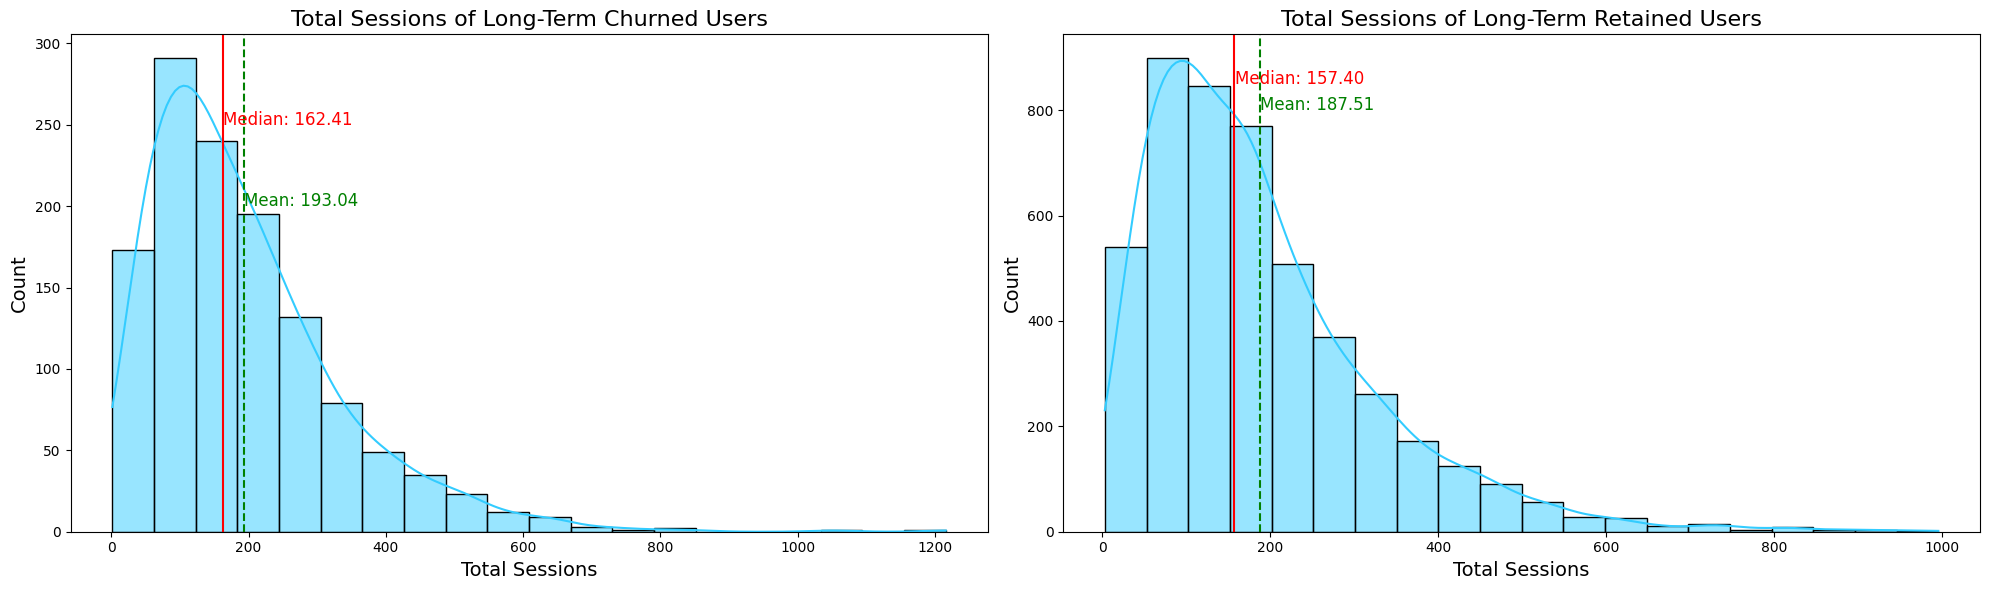

In [37]:
#not neccessary
plt.figure(figsize=(20, 6))

# Plot 1:
plt.subplot(1, 2, 1)
sns.histplot(long_term_users_churned['total_sessions'], kde=True, color='#33ccff', edgecolor='black', bins=20)


# Median and Mean values for churned users
median_value_churned = long_term_users_churned['total_sessions'].median()
mean_value_churned = long_term_users_churned['total_sessions'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_churned, color='red', linestyle='-', label=f'Median: {median_value_churned:.2f}')
plt.axvline(mean_value_churned, color='green', linestyle='--', label=f'Mean: {mean_value_churned:.2f}')
plt.text(median_value_churned + 0.5, 250, f'Median: {median_value_churned:.2f}', color='red', fontsize=12)
plt.text(mean_value_churned + 0.5, 200, f'Mean: {mean_value_churned:.2f}', color='green', fontsize=12)

plt.title('Driving Days of Long-Term Churned Users', fontsize=16)
plt.xlabel('Driving Days', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.title("Total Sessions of Long-Term Churned Users", fontsize=16)
plt.xlabel('Total Sessions', fontsize=14)
plt.ylabel('Count', fontsize=14)




# plot1
plt.subplot(1, 2, 2)
sns.histplot(long_term_users_retained['total_sessions'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for retained users
median_value_retained = long_term_users_retained['total_sessions'].median()
mean_value_retained = long_term_users_retained['total_sessions'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_retained, color='red', linestyle='-', label=f'Median: {median_value_retained:.2f}')
plt.axvline(mean_value_retained, color='green', linestyle='--', label=f'Mean: {mean_value_retained:.2f}')
plt.text(median_value_retained + 0.5, 850, f'Median: {median_value_retained:.2f}', color='red', fontsize=12)
plt.text(mean_value_retained + 0.5, 800, f'Mean: {mean_value_retained:.2f}', color='green', fontsize=12)

plt.title('Total Sessions of Long-Term Retained Users', fontsize=16)
plt.xlabel('Total Sessions', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

Does not have much impact on churn.

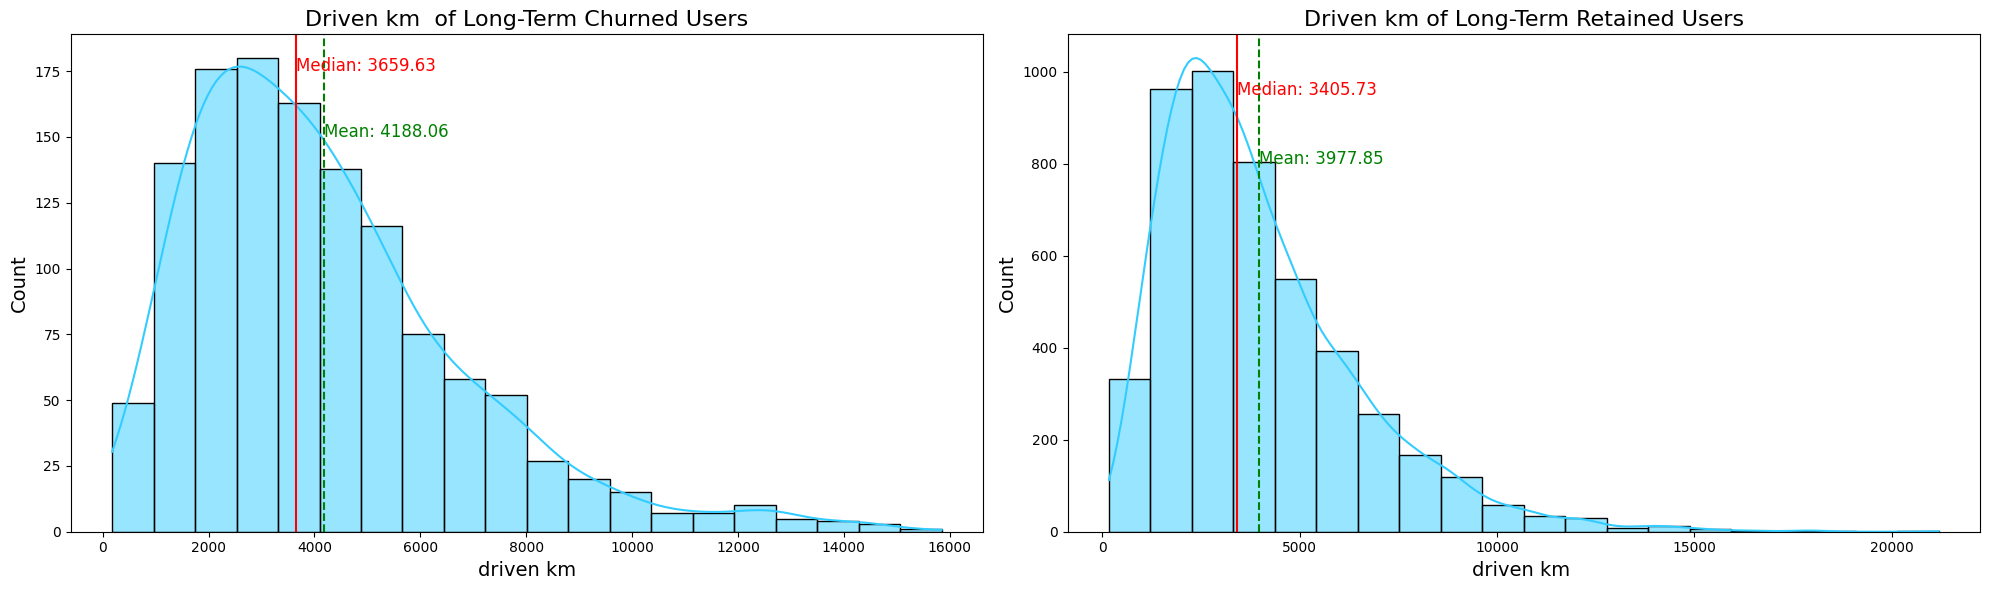

In [38]:
plt.figure(figsize=(20, 6))

# Plot 1:
plt.subplot(1, 2, 1)
sns.histplot(long_term_users_churned['driven_km_drives'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for churned users
median_value_churned = long_term_users_churned['driven_km_drives'].median()
mean_value_churned = long_term_users_churned['driven_km_drives'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_churned, color='red', linestyle='-', label=f'Median: {median_value_churned:.2f}')
plt.axvline(mean_value_churned, color='green', linestyle='--', label=f'Mean: {mean_value_churned:.2f}')
plt.text(median_value_churned + 0.5, 175, f'Median: {median_value_churned:.2f}', color='red', fontsize=12)
plt.text(mean_value_churned + 0.5, 150, f'Mean: {mean_value_churned:.2f}', color='green', fontsize=12)


plt.title("Driven km  of Long-Term Churned Users", fontsize=16)
plt.xlabel('driven km', fontsize=14)
plt.ylabel('Count', fontsize=14)



# Plot 2:
plt.subplot(1, 2, 2)
sns.histplot(long_term_users_retained['driven_km_drives'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for retained users
median_value_retained = long_term_users_retained['driven_km_drives'].median()
mean_value_retained = long_term_users_retained['driven_km_drives'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_retained, color='red', linestyle='-', label=f'Median: {median_value_retained:.2f}')
plt.axvline(mean_value_retained, color='green', linestyle='--', label=f'Mean: {mean_value_retained:.2f}')
plt.text(median_value_retained + 0.5, 950, f'Median: {median_value_retained:.2f}', color='red', fontsize=12)
plt.text(mean_value_retained + 0.5, 800, f'Mean: {mean_value_retained:.2f}', color='green', fontsize=12)

plt.title('Driven km of Long-Term Retained Users', fontsize=16)
plt.xlabel('driven km ', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.tight_layout()
plt.show()

Does not have much impact on churn.

# Very long term users

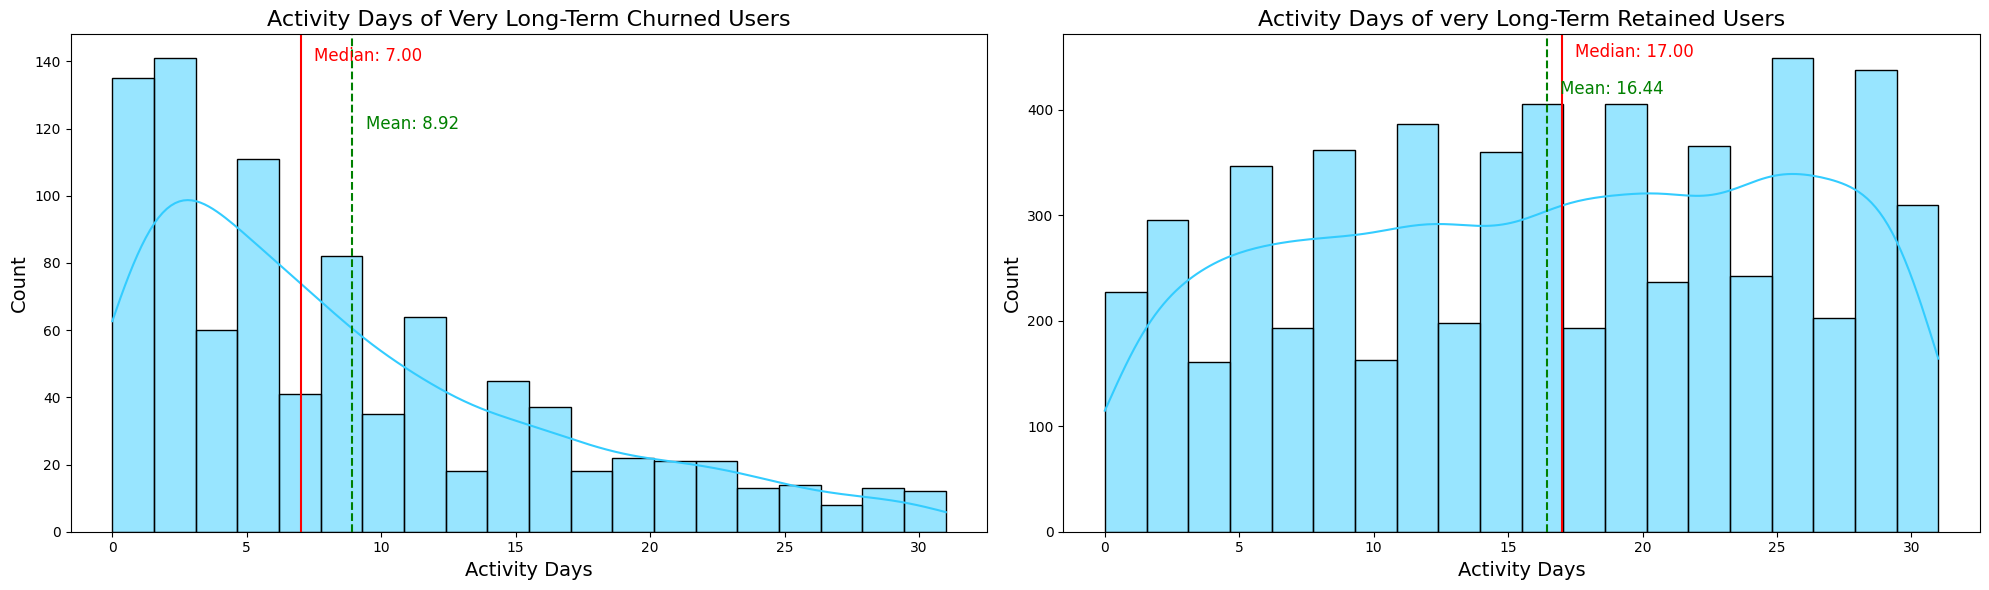

In [39]:
plt.figure(figsize=(20, 6))

# Plot 1
plt.subplot(1, 2, 1)
very_long_term_users_churned = data_churned[data_churned['days_segment'] == "very_long_term_users"]

# Plot histogram for activity days of long-term users who churned
sns.histplot(very_long_term_users_churned['activity_days'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for churned users
median_value_churned = very_long_term_users_churned['activity_days'].median()
mean_value_churned = very_long_term_users_churned['activity_days'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_churned, color='red', linestyle='-', label=f'Median: {median_value_churned:.2f}')
plt.axvline(mean_value_churned, color='green', linestyle='--', label=f'Mean: {mean_value_churned:.2f}')
plt.text(median_value_churned + 0.5, 140, f'Median: {median_value_churned:.2f}', color='red', fontsize=12)
plt.text(mean_value_churned + 0.5, 120, f'Mean: {mean_value_churned:.2f}', color='green', fontsize=12)

plt.title('Activity Days of Very Long-Term Churned Users', fontsize=16)
plt.xlabel('Activity Days', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Plot 2
plt.subplot(1, 2, 2)
very_long_term_users_retained = data_retained[data_retained['days_segment'] == "very_long_term_users"]

# Plot histogram for activity days of long-term users who retained
sns.histplot(very_long_term_users_retained['activity_days'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for retained users
median_value_retained = very_long_term_users_retained['activity_days'].median()
mean_value_retained = very_long_term_users_retained['activity_days'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_retained, color='red', linestyle='-', label=f'Median: {median_value_retained:.2f}')
plt.axvline(mean_value_retained, color='green', linestyle='--', label=f'Mean: {mean_value_retained:.2f}')
plt.text(median_value_retained + 0.5, 450, f'Median: {median_value_retained:.2f}', color='red', fontsize=12)
plt.text(mean_value_retained + 0.5, 415, f'Mean: {mean_value_retained:.2f}', color='green', fontsize=12)

plt.title('Activity Days of very Long-Term Retained Users', fontsize=16)
plt.xlabel('Activity Days', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()


## Low Activity, High Risk: Understanding Churn Drivers

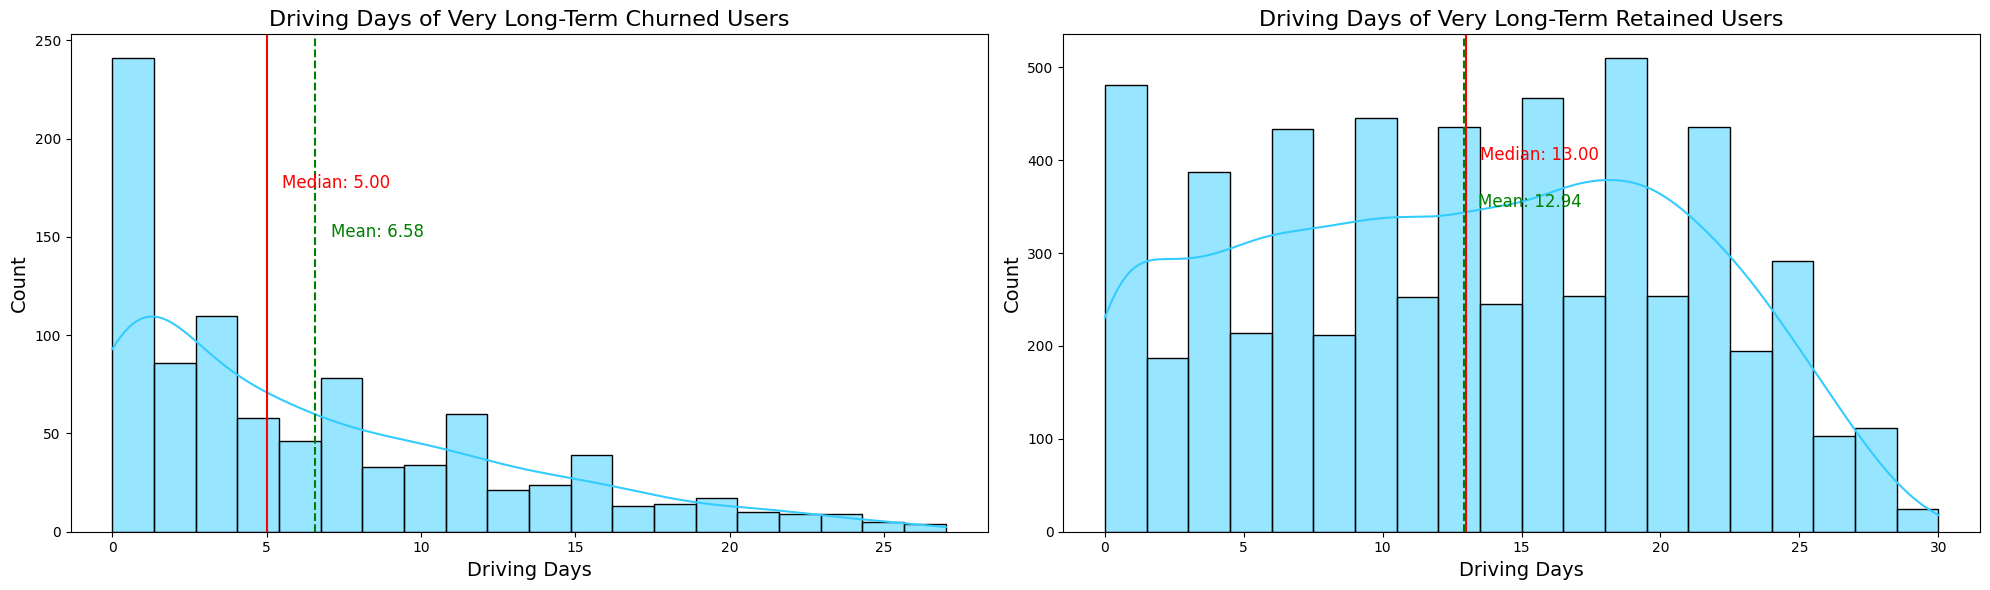

In [40]:
plt.figure(figsize=(20, 6))

# Plot 1:
plt.subplot(1, 2, 1)


sns.histplot(very_long_term_users_churned['driving_days'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for churned users
median_value_churned = very_long_term_users_churned['driving_days'].median()
mean_value_churned = very_long_term_users_churned['driving_days'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_churned, color='red', linestyle='-', label=f'Median: {median_value_churned:.2f}')
plt.axvline(mean_value_churned, color='green', linestyle='--', label=f'Mean: {mean_value_churned:.2f}')
plt.text(median_value_churned + 0.5, 175, f'Median: {median_value_churned:.2f}', color='red', fontsize=12)
plt.text(mean_value_churned + 0.5, 150, f'Mean: {mean_value_churned:.2f}', color='green', fontsize=12)

plt.title('Driving Days of Very Long-Term Churned Users', fontsize=16)
plt.xlabel('Driving Days', fontsize=14)
plt.ylabel('Count', fontsize=14)


# Plot 2:
plt.subplot(1, 2, 2)



sns.histplot(very_long_term_users_retained['driving_days'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for retained users
median_value_retained = very_long_term_users_retained['driving_days'].median()
mean_value_retained = very_long_term_users_retained['driving_days'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_retained, color='red', linestyle='-', label=f'Median: {median_value_retained:.2f}')
plt.axvline(mean_value_retained, color='green', linestyle='--', label=f'Mean: {mean_value_retained:.2f}')
plt.text(median_value_retained + 0.5, 400, f'Median: {median_value_retained:.2f}', color='red', fontsize=12)
plt.text(mean_value_retained + 0.5, 350, f'Mean: {mean_value_retained:.2f}', color='green', fontsize=12)

plt.title('Driving Days of Very Long-Term Retained Users', fontsize=16)
plt.xlabel('Driving Days', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.tight_layout()
plt.show()



## Driving Less, Leaving More: The Churn Connection

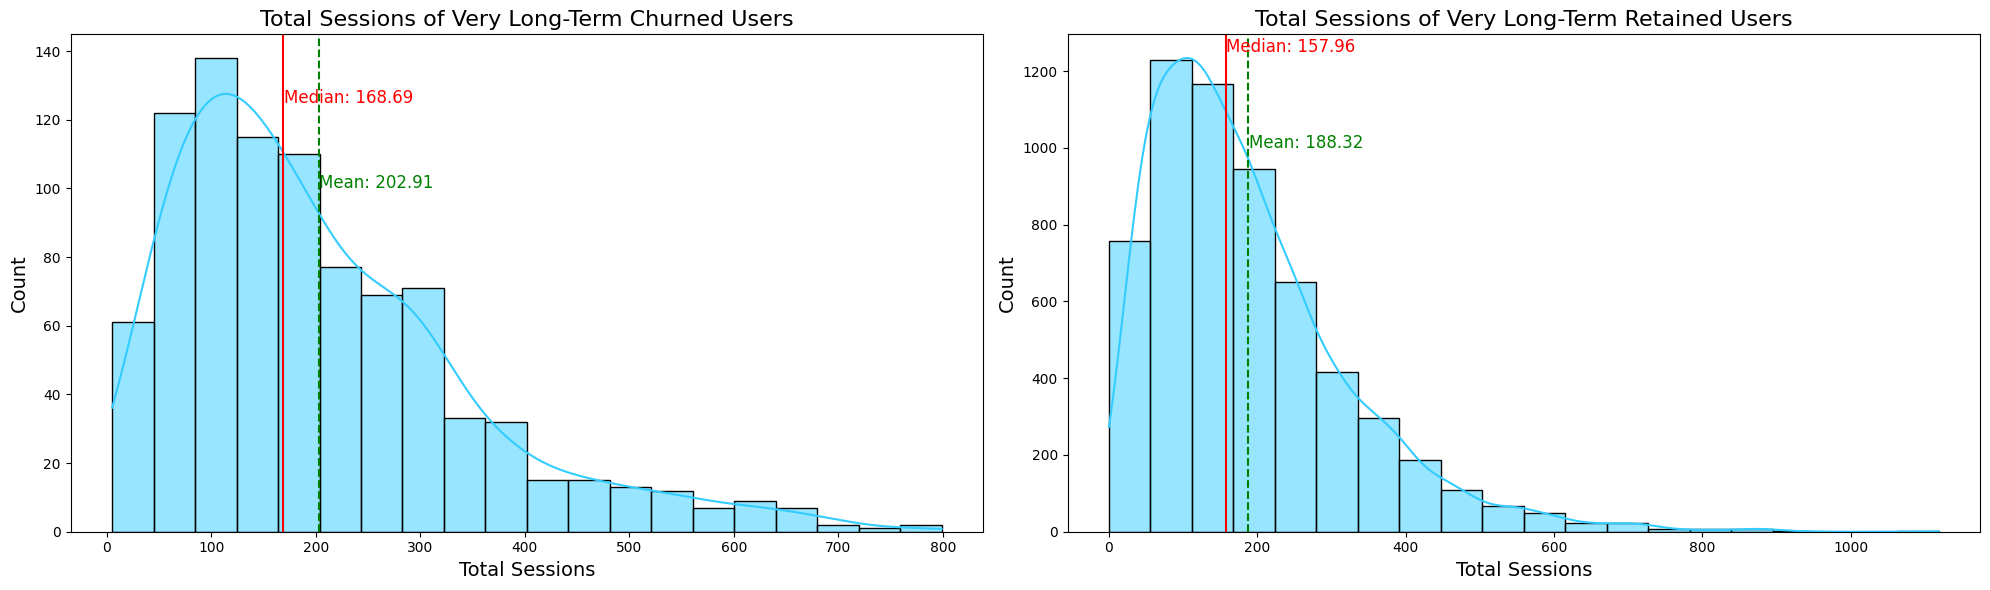

In [41]:
plt.figure(figsize=(20, 6))

# Plot 1:
plt.subplot(1, 2, 1)



sns.histplot(very_long_term_users_churned['total_sessions'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for churned users
median_value_churned = very_long_term_users_churned['total_sessions'].median()
mean_value_churned = very_long_term_users_churned['total_sessions'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_churned, color='red', linestyle='-', label=f'Median: {median_value_churned:.2f}')
plt.axvline(mean_value_churned, color='green', linestyle='--', label=f'Mean: {mean_value_churned:.2f}')
plt.text(median_value_churned + 0.5, 125, f'Median: {median_value_churned:.2f}', color='red', fontsize=12)
plt.text(mean_value_churned + 0.5, 100, f'Mean: {mean_value_churned:.2f}', color='green', fontsize=12)

plt.title("Total Sessions of Very Long-Term Churned Users", fontsize=16)
plt.xlabel('Total Sessions', fontsize=14)
plt.ylabel('Count', fontsize=14)


# Plot 2: For very_long_term_users who retained
plt.subplot(1, 2, 2)



sns.histplot(very_long_term_users_retained['total_sessions'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for retained users
median_value_retained = very_long_term_users_retained['total_sessions'].median()
mean_value_retained = very_long_term_users_retained['total_sessions'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_retained, color='red', linestyle='-', label=f'Median: {median_value_retained:.2f}')
plt.axvline(mean_value_retained, color='green', linestyle='--', label=f'Mean: {mean_value_retained:.2f}')
plt.text(median_value_retained + 0.5, 1250, f'Median: {median_value_retained:.2f}', color='red', fontsize=12)
plt.text(mean_value_retained + 0.5, 1000, f'Mean: {mean_value_retained:.2f}', color='green', fontsize=12)

plt.title("Total Sessions of Very Long-Term Retained Users", fontsize=16)
plt.xlabel('Total Sessions', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.tight_layout()
plt.show()


Not much impact on churn

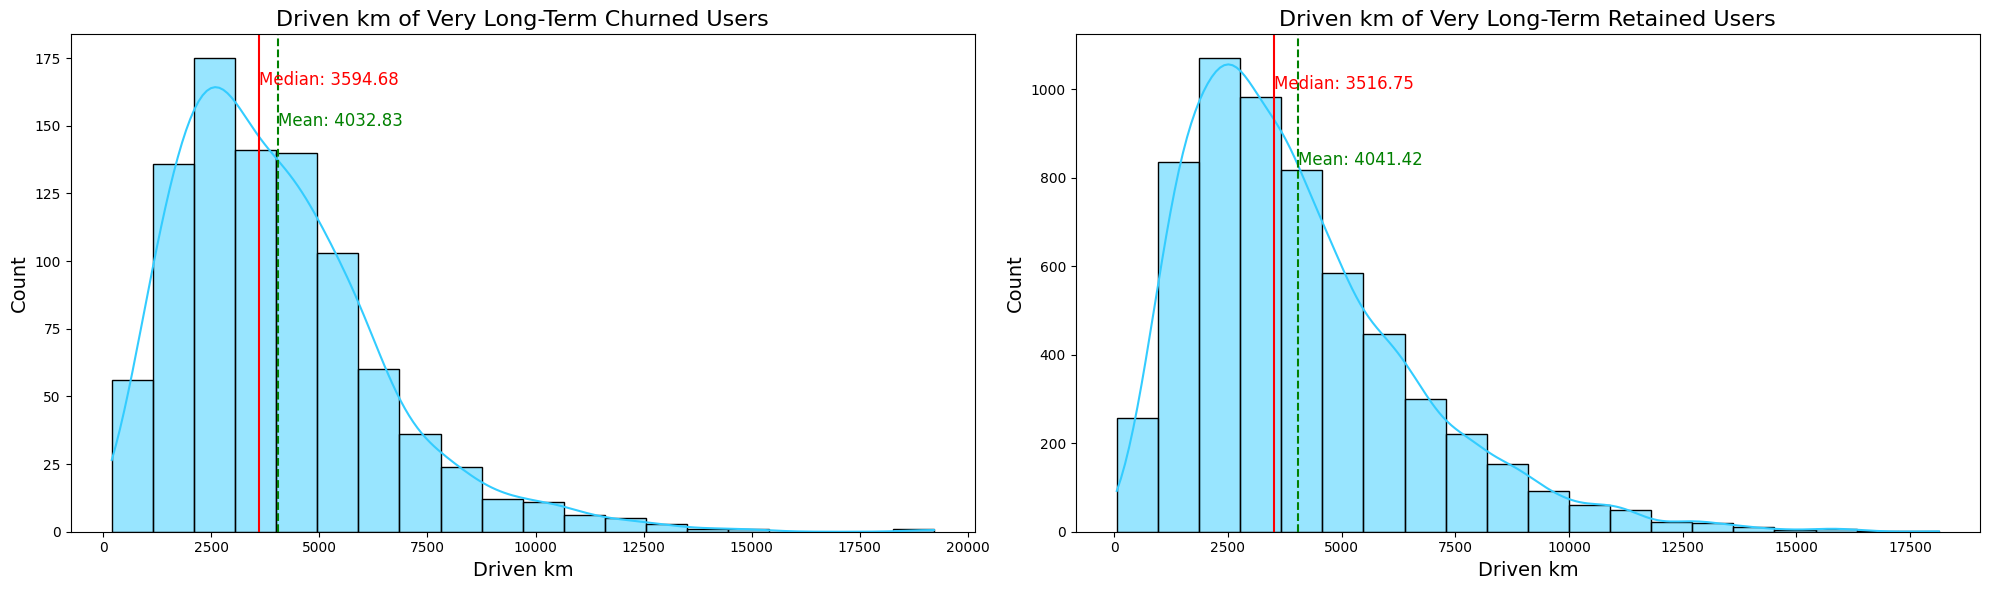

In [42]:
plt.figure(figsize=(20, 6))

# Plot 1:
plt.subplot(1, 2, 1)



sns.histplot(very_long_term_users_churned['driven_km_drives'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for churned users
median_value_churned = very_long_term_users_churned['driven_km_drives'].median()
mean_value_churned = very_long_term_users_churned['driven_km_drives'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_churned, color='red', linestyle='-', label=f'Median: {median_value_churned:.2f}')
plt.axvline(mean_value_churned, color='green', linestyle='--', label=f'Mean: {mean_value_churned:.2f}')
plt.text(median_value_churned + 0.5, 165, f'Median: {median_value_churned:.2f}', color='red', fontsize=12)
plt.text(mean_value_churned + 0.5, 150, f'Mean: {mean_value_churned:.2f}', color='green', fontsize=12)

plt.title("Driven km of Very Long-Term Churned Users", fontsize=16)
plt.xlabel('Driven km', fontsize=14)
plt.ylabel('Count', fontsize=14)


# Plot 2: For very_long_term_users who retained
plt.subplot(1, 2, 2)



sns.histplot(very_long_term_users_retained['driven_km_drives'], kde=True, color='#33ccff', edgecolor='black', bins=20)

# Median and Mean values for retained users
median_value_retained = very_long_term_users_retained['driven_km_drives'].median()
mean_value_retained = very_long_term_users_retained['driven_km_drives'].mean()

# Add median and mean lines with labels
plt.axvline(median_value_retained, color='red', linestyle='-', label=f'Median: {median_value_retained:.2f}')
plt.axvline(mean_value_retained, color='green', linestyle='--', label=f'Mean: {mean_value_retained:.2f}')
plt.text(median_value_retained + 0.5, 1000, f'Median: {median_value_retained:.2f}', color='red', fontsize=12)
plt.text(mean_value_retained + 0.5, 830, f'Mean: {mean_value_retained:.2f}', color='green', fontsize=12)

plt.title('Driven km of Very Long-Term Retained Users', fontsize=16)
plt.xlabel('Driven km', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.tight_layout()
plt.show()


Not much impact on churn

In [43]:
data["label"].unique()

array(['retained', 'churned'], dtype=object)

In [44]:
data_corr=pd.DataFrame(data)
data_corr["label"] = data_corr["label"].replace({"retained": 0, "churned": 1})
# Distribution of numeric values of the cleaned data
data_numeric_corr = pd.DataFrame()

for column in data_corr.columns:

    if data_corr[column].dtypes == "int64" or data_corr[column].dtypes == "float64":
        data_numeric_corr[column] = data_corr[column]


<ipython-input-44-c5577930631b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_corr["label"] = data_corr["label"].replace({"retained": 0, "churned": 1})


In [45]:

#correlation
correlation = data_numeric_corr.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)
correlation

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
ID,1.000000,0.004425,0.012516,0.011741,0.005986,-0.005300,-0.000560,0.000153,-0.002123,-0.000181,-0.000891,-0.000981
label,0.004425,1.000000,0.038045,0.038548,0.025046,-0.129263,0.055537,0.020051,0.019050,0.035678,-0.303851,-0.294259
sessions,0.012516,0.038045,1.000000,0.996843,0.590265,0.006441,0.005252,0.005220,0.003815,-0.005800,0.024594,0.020228
drives,0.011741,0.038548,0.996843,1.000000,0.588118,0.006001,0.004551,0.006896,0.003708,-0.005376,0.024324,0.019975
total_sessions,0.005986,0.025046,0.590265,0.588118,1.000000,0.006180,-0.000047,0.007659,0.001690,-0.001457,0.012932,0.009798
n_days_after_onboarding,-0.005300,-0.129263,0.006441,0.006001,0.006180,1.000000,-0.004536,-0.006433,-0.005056,-0.010715,-0.009418,-0.007321
total_navigations_fav1,-0.000560,0.055537,0.005252,0.004551,-0.000047,-0.004536,1.000000,0.003734,-0.006262,0.005619,0.010318,0.010024
total_navigations_fav2,0.000153,0.020051,0.005220,0.006896,0.007659,-0.006433,0.003734,1.000000,0.000159,-0.005326,-0.004836,0.000938
driven_km_drives,-0.002123,0.019050,0.003815,0.003708,0.001690,-0.005056,-0.006262,0.000159,1.000000,0.697977,-0.004196,-0.007099
duration_minutes_drives,-0.000181,0.035678,-0.005800,-0.005376,-0.001457,-0.010715,0.005619,-0.005326,0.697977,1.000000,-0.003898,-0.006239


<Axes: >

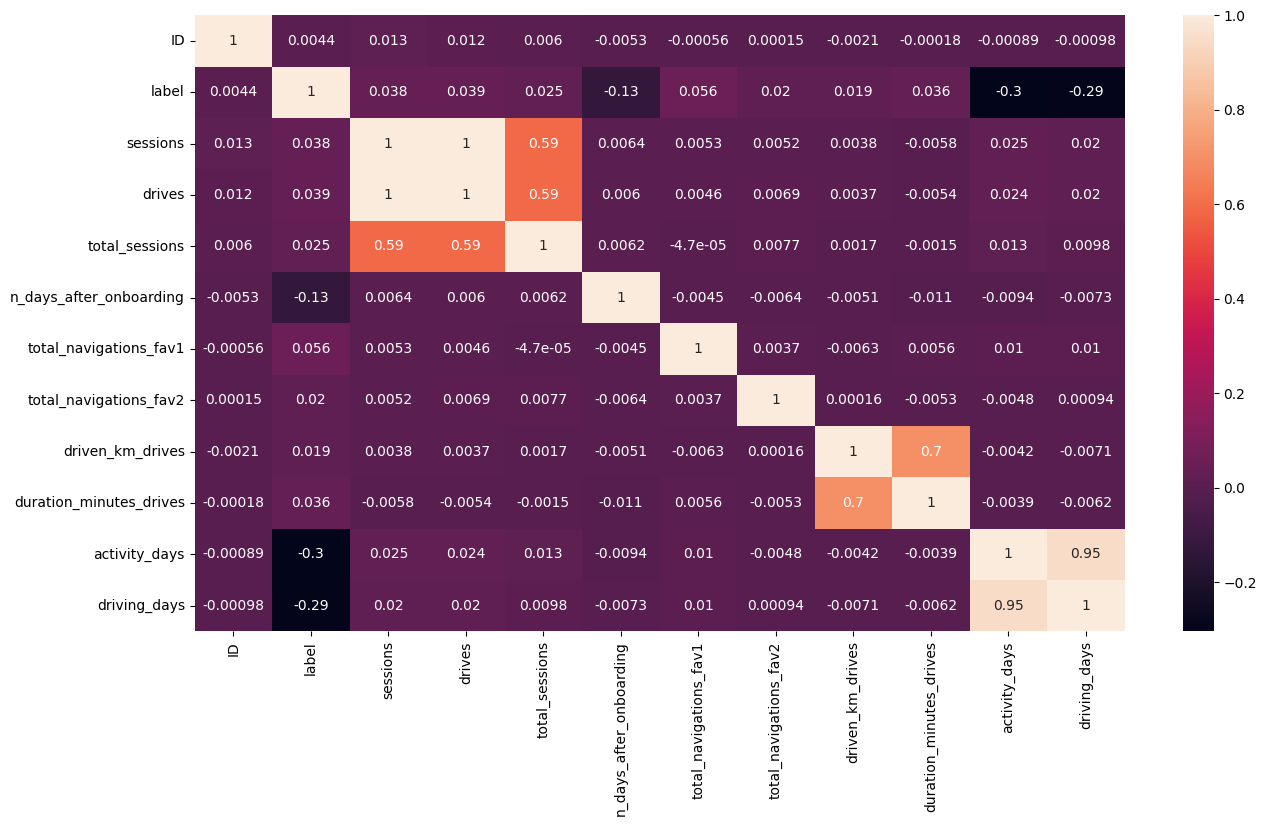

In [46]:
plt.figure(figsize = [15,8])
sns.heatmap(correlation, annot = True)

As the insights from EDA ,Correlation matrix also shows that n_days_after_onboarding, activity_days and driving_days related to the label(churn) the most. The activity_days and driving_days are also highly correlated to each other.

# Modelling

In [47]:
#Data preprocessing

In [48]:
data_corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14299 non-null  int64  
 1   label                    14299 non-null  int64  
 2   sessions                 14299 non-null  int64  
 3   drives                   14299 non-null  int64  
 4   total_sessions           14299 non-null  float64
 5   n_days_after_onboarding  14299 non-null  int64  
 6   total_navigations_fav1   14299 non-null  int64  
 7   total_navigations_fav2   14299 non-null  int64  
 8   driven_km_drives         14299 non-null  float64
 9   duration_minutes_drives  14299 non-null  float64
 10  activity_days            14299 non-null  int64  
 11  driving_days             14299 non-null  int64  
 12  device                   14299 non-null  object 
dtypes: float64(3), int64(9), object(1)
memory usage: 1.5+ MB


In [49]:
data_corr.isnull().sum()

,0
ID,0
label,0
sessions,0
drives,0
total_sessions,0
n_days_after_onboarding,0
total_navigations_fav1,0
total_navigations_fav2,0
driven_km_drives,0
duration_minutes_drives,0


In [50]:
data_corr.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,0,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,0,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,0,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,0,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,0,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [51]:
# label encode "device"
le = LabelEncoder()
data_corr['device'] = le.fit_transform(data_corr['device'])

In [52]:
data_corr["device"].unique()

array([0, 1])

In [53]:
# Training using data
X=data_corr.drop(["label","ID"],axis=1)
y=data_corr["label"]

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=342,test_size=0.2,stratify=y)

In [54]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11439, 11), (11439,), (2860, 11), (2860,))

# Baseline Models

# Model 1 - RandomForest Classifier ( Baseline)

In [55]:
# model
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = baseline_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Random Forest Training Accuracy:", training_accuracy)
y_pred = baseline_rf.predict(X_test)

# Evaluate the model
print("Random Forest Testing Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# overfitted

# aCCURACY 82%
# A perfect training accuracy of 1.0 suggests overfitting.
# class 0 High precision (0.84), recall (0.97), and F1-score (0.90).
# class 1 F1-score (0.18) reflects poor balance between precision and recall.

Random Forest Training Accuracy: 1.0
Random Forest Testing Accuracy: 0.8213286713286714

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      2353
           1       0.48      0.11      0.18       507

    accuracy                           0.82      2860
   macro avg       0.66      0.54      0.54      2860
weighted avg       0.77      0.82      0.77      2860



# Model2 -Gradient Boosting Models (Baseline)

In [56]:
#model
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("XGBoost Testing Accuracy:", accuracy_score(y_test, y_pred))
y_train_pred=xgb.predict(X_train)
print("XGBoost Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Accuracy 81%
# High precision (0.84), recall (0.95), and F1-score (0.89), indicating the model performs well on the majority class.
# F1-score (0.22) indicates poor overall performance for the minority class.
# The significant accuracy gap suggests the model is likely overfitting to the training data.

XGBoost Testing Accuracy: 0.8122377622377622
XGBoost Training Accuracy: 0.945362356849375

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      2353
           1       0.42      0.15      0.22       507

    accuracy                           0.81      2860
   macro avg       0.63      0.55      0.56      2860
weighted avg       0.76      0.81      0.77      2860



# Model 3 SVC (Baseline)

In [57]:
# MODEL
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("SVM Testing Accuracy:", accuracy_score(y_test, y_pred))

y_train_pred=svm.predict(X_train)
print("SVM Training Accuracy:", accuracy_score(y_train, y_train_pred))

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Accuracy 82%
# Recall 1 for class 0, meaning the model identifies all instances of class 0 correctly.
# Recall 0  for class 1,and F1-score for class 1 are 0.00 because the model never predicts this class.
# The macro average scores are much lower (precision = 0.41, recall = 0.50, F1-score = 0.45), indicating poor overall performance across all classes.

SVM Testing Accuracy: 0.8227272727272728
SVM Training Accuracy: 0.8226243552758108

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90      2353
           1       0.00      0.00      0.00       507

    accuracy                           0.82      2860
   macro avg       0.41      0.50      0.45      2860
weighted avg       0.68      0.82      0.74      2860



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Model 4- Logistic Regression (Baseline)

In [58]:

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)


y_pred = log_reg.predict(X_test_scaled)
print("Logistic Regression Testing Accuracy:", accuracy_score(y_test, y_pred))
y_train_pred = log_reg.predict(X_train_scaled)
print("Logistic Regression Training Accuracy:", accuracy_score(y_train, y_train_pred))

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# class 0 High precision (0.83), recall (0.98), and F1-score (0.90).

# class 1 Precision (0.56) is better than Random Forest or XGBoost, meaning when it predicts class 1, it's correct 56% of the time.
# Recall (0.09) is still low, indicating the model is not identifying most minority class instances.
# F1-score (0.16) reflects an imbalance in precision and recall.

# Slightly higher at 82.6%, but heavily influenced by the majority class.




Logistic Regression Testing Accuracy: 0.8262237762237762
Logistic Regression Training Accuracy: 0.8248098610018358

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      2353
           1       0.56      0.09      0.16       507

    accuracy                           0.83      2860
   macro avg       0.70      0.54      0.53      2860
weighted avg       0.79      0.83      0.77      2860




# Model 5-Neural Network

In [59]:


mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("Neural Network Testing Accuracy:", accuracy_score(y_test, y_pred))

y_train_pred=mlp.predict(X_train)
print("MLP Classifier Training Accuracy:", accuracy_score(y_train, y_train_pred))

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Class 0 Performance: Precision: 0.83, Recall: 0.98, F1-Score: 0.90. The model performs very well in predicting the majority class.
# Class 1 Performance:-Precision: 0.33, Recall: 0.05, F1-Score: 0.09.-The minority class is poorly predicted, with a low recall indicating that only 5% of actual class 1 instances are identified.
#Overall Accuracy:-81.3%, but this heavily reflects the model's focus on the majority clas

Neural Network Testing Accuracy: 0.8136363636363636
MLP Classifier Training Accuracy: 0.8200891686336218

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      2353
           1       0.33      0.05      0.09       507

    accuracy                           0.81      2860
   macro avg       0.58      0.51      0.49      2860
weighted avg       0.74      0.81      0.75      2860



All the baseline models seems to has comparitevely very low precision and recall on class 1 compared to class 0. It may be due to imbalanced dataset.As per our EDA class 1 (churn) is 17.7% while that of class 0 is 82.3 %(retained). I used stratify with makes ensures that the proportions of the classes in both training and test sets are similar to the original dataset, it does not address the underlying imbalance in the dataset itself. We need to use balanced class weights or resampling techniques like smote.


# Hyperparameter tuning

# Model 6 Random Forest ( with balanced class weights)

In [60]:
# Random Forest with balanced weights
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",  # Automatically adjusts weights inversely proportional to class frequency
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    n_estimators=100
)
rf.fit(X_train, y_train)


y_train_pred = rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Random Forest Training Accuracy:", training_accuracy)
y_pred=rf.predict(X_test)


# Evaluate the model
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Training Accuracy:-80.7% indicates the model is not overfitting and has generalized well to the training data.
# Testing Accuracy:-73.7%, lower than models without class balancing, but this trade-off has enhanced minority class recall.
# Class 0 Performance:-Precision: 0.89, Recall: 0.78, F1-Score: 0.83.-Slight decrease in recall due to focus on class 1.
# Class 1 Performance:-Precision: 0.35, Recall: 0.54, F1-Score: 0.42.-Significant improvement in recall compared to earlier models, making it better at identifying class 1
# Macro Average:-Precision: 0.62, Recall: 0.66, F1-Score: 0.63 reflects a better balance between classes.-Weighted averages remain strong due to the prevalence of class 0.


Random Forest Training Accuracy: 0.8074132354226768
Testing Accuracy: 0.7374125874125874

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      2353
           1       0.35      0.54      0.42       507

    accuracy                           0.74      2860
   macro avg       0.62      0.66      0.63      2860
weighted avg       0.79      0.74      0.76      2860



# MODEL 7

In [61]:
# Random Search CV - Random Forest-balanced weights

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],

}

rf = RandomForestClassifier(random_state=42, class_weight="balanced", max_features="sqrt",criterion="entropy")
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=3, random_state=42)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
y_pred=rf_random.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Make predictions on the training data
y_train_pred = rf_random.predict(X_train)
# Calculate the training accuracy
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Random Forest Training Accuracy:", training_accuracy)
#Good performance on class 0: The model is highly accurate for the majority class (class 0) with high precision and recall.
#Low performance on class 1: The model performs poorly for the minority class (class 1), with a low recall (9%) and precision (52%).
# overfitted

# The model may have overfitted due to the trees being too complex



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Accuracy: 0.8241258741258741

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      2353
           1       0.52      0.09      0.16       507

    accuracy                           0.82      2860
   macro avg       0.68      0.54      0.53      2860
weighted avg       0.78      0.82      0.77      2860

Random Forest Training Accuracy: 1.0


# Model 8

In [62]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],  # Use a subset of features for each split to reduce overfitting
    'criterion': ['gini', 'entropy'],  # Split criterion (Gini impurity or Entropy)
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",  # Automatically adjusts weights
    n_jobs=-1
)

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

rf_random.fit(X_train_smote, y_train_smote)

print("Best Parameters:", rf_random.best_params_)

y_pred = rf_random.predict(X_test)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred))
y_train_pred = rf_random.predict(X_train_smote)
training_accuracy = accuracy_score(y_train_smote, y_train_pred)
print("Random Forest Training Accuracy:", training_accuracy)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}
Testing Accuracy: 0.7174825174825175

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.87      0.77      0.82      2353
           1       0.31      0.47      0.37       507

    accuracy                           0.72      2860
   macro avg       0.59      0.62      0.59      2860
weighted avg       0.77      0.72      0.74      2860

Random Forest Training Accuracy: 0.9814027630180658


# Model 9

In [ ]:
#Address overfitting
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the parameter grid for RandomizedSearchCV with narrowed hyperparameters to avoid overfitting
param_grid = {
    'n_estimators': [100, 150, 200],  # Fewer trees to avoid overfitting
    'max_depth': [10, 15, 20],  # Limit tree depth to prevent overfitting
    'min_samples_split': [10, 15],  # Increase min_samples_split to prevent overfitting
    'min_samples_leaf': [4, 5],  # Increase min_samples_leaf to prevent overfitting
    'max_features': ['sqrt', 'log2'],  # Use a subset of features for each split to reduce overfitting
    'criterion': ['gini', 'entropy'],  # Split criterion (Gini impurity or Entropy)
}

# Random Forest classifier with class weights balanced
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",  # Automatically adjusts weights
    n_jobs=-1
)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  # Number of random configurations to try
    cv=3,  # Use 3-fold cross-validation
    random_state=42,
    n_jobs=-1,  # Use all processors
    verbose=2
)

# Fit the RandomizedSearchCV model on the balanced training data (after SMOTE)
rf_random.fit(X_train_smote, y_train_smote)


print("Best Parameters:", rf_random.best_params_)
y_pred = rf_random.predict(X_test)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred))
y_train_pred = rf_random.predict(X_train_smote)
training_accuracy = accuracy_score(y_train_smote, y_train_pred)
print("Random Forest Training Accuracy:", training_accuracy)

#still overfitted

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}
Testing Accuracy: 0.7146853146853147

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.87      0.76      0.82      2353
           1       0.31      0.48      0.37       507

    accuracy                           0.71      2860
   macro avg       0.59      0.62      0.59      2860
weighted avg       0.77      0.71      0.74      2860

Random Forest Training Accuracy: 0.9391073326248671


# Model 10

In [64]:


# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Train a Random Forest model on the oversampled dataset
rf_smote = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    n_estimators=200,
    max_features="sqrt",
    criterion="entropy"
)
rf_smote.fit(X_train_smote, y_train_smote)

# Evaluate the model on the testing set
y_pred_smote = rf_smote.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
y_train_pred_smote = rf_smote.predict(X_train_smote)
print("Random Forest Training Accuracy (with SMOTE):", accuracy_score(y_train_smote, y_train_pred_smote))

# Improved Recall for Class 1: The recall for class 1 has improved from the previous models (45%) due to the oversampling of the minority class, but still remains low.
# Overfitting concern: The training accuracy is 100%, which suggests overfitting to the synthetic data. This is a common issue with oversampling techniques, where the model becomes too specific to the training data.

Accuracy: 0.7202797202797203

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      2353
           1       0.30      0.45      0.36       507

    accuracy                           0.72      2860
   macro avg       0.59      0.61      0.59      2860
weighted avg       0.77      0.72      0.74      2860

Random Forest Training Accuracy (with SMOTE): 1.0


# Logistic Regression Models (Hypertuning)

# Model  11

In [65]:
# scaled, Logistic Regresor, weight balanced
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



log_reg_balanced = LogisticRegression(
    random_state=42,
    class_weight='balanced',  # Penalize misclassification of minority class
    max_iter=1000
)
log_reg_balanced.fit(X_train_scaled, y_train)

# Evaluate
y_pred = log_reg_balanced.predict(X_test_scaled)
print("Logistic Regression Testing Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_train_pred = log_reg_balanced.predict(X_train_scaled)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Random Forest Training Accuracy:", training_accuracy)
# Class Imbalance Impact: While recall for class 1 (minority class) is high (67%), precision for class 1 is low (31%), indicating that many of the predicted positive cases (class 1) are actually false positives.
# Precision for Class 0: The precision for class 0 is 91%, which is high, but the recall is only 67%, suggesting that many true positives for class 0 are being missed.
# Training Accuracy: The model shows reasonable performance on both training and testing sets, suggesting that it is not overfitting but may still benefit from further tuning.

Logistic Regression Testing Accuracy: 0.6744755244755245
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      2353
           1       0.31      0.67      0.42       507

    accuracy                           0.67      2860
   macro avg       0.61      0.67      0.60      2860
weighted avg       0.80      0.67      0.71      2860

Random Forest Training Accuracy: 0.6775941952967917


# Model 12

In [66]:
# scaled, Logistic Regresor, weight balanced, Randomsearch
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Regularization parameter, log scale
    'solver': ['lbfgs', 'saga'],  # Solvers to choose from
    'max_iter': [1000, 2000, 5000],  # Number of iterations
    'penalty': ['l2']  # Regularization type
}


log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_train_scaled, y_train)
print("Best Parameters from Randomized Search:", random_search.best_params_)
best_log_reg = random_search.best_estimator_

y_pred = best_log_reg.predict(X_test_scaled)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_train_pred = best_log_reg.predict(X_train_scaled)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", training_accuracy)
\
# Class 0 Precision: The precision for class 0 is high, indicating that when the model predicts class 0, it is correct most of the time (90%). However, the recall for class 0 is lower (67%), suggesting that many true instances of class 0 are missed.
# Class 1 Recall: The recall for class 1 is higher (67%), showing that the model is good at identifying class 1 instances, but precision is low (31%), indicating that a significant portion of predicted class 1 are false positives.
# Overfitting: The close performance between the training and testing accuracy suggests the model is not overfitting. The performance on the test data is consistent with what is observed on the training data


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters from Randomized Search: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 2000, 'C': 0.08858667904100823}
Testing Accuracy: 0.6737762237762238
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      2353
           1       0.31      0.67      0.42       507

    accuracy                           0.67      2860
   macro avg       0.61      0.67      0.60      2860
weighted avg       0.80      0.67      0.71      2860

Training Accuracy: 0.6780312964419967


# XGB (hypertuning)

# MODEL 13

In [78]:
# XGB , Random Search
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 1, 10],  # L1 regularization
    'reg_lambda': [1, 5, 10]  # L2 regularization
}


xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)
best_xgb = random_search.best_estimator_
y_test_pred = best_xgb.predict(X_test)
print("XGBoost Testing Accuracy with Tuned Hyperparameters:", accuracy_score(y_test, y_test_pred))
y_train_pred = best_xgb.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("XGBoost Training Accuracy:", training_accuracy)

# Evaluate the model's performance on the test set
print(classification_report(y_test, y_test_pred))

# Class 0 Precision: The model has a very high recall for class 0 (98%) and decent precision (83%). This suggests that the model is good at identifying class 0 instances, but there might be a high number of false positives for class 1.
# Class 1 Recall: The recall for class 1 is quite low (7%), and precision is also low (49%), indicating the model is not identifying class 1 well, even though it tries to predict a higher proportion of class 1 instances.
# Overfitting: The training accuracy (83.6%) is slightly higher than the testing accuracy (82.2%), which might indicate some overfitting, although the difference is relatively small.

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 5, 'colsample_bytree': 0.6}
Best Cross-Validation Accuracy: 0.8252469621470407
XGBoost Testing Accuracy with Tuned Hyperparameters: 0.8223776223776224
XGBoost Training Accuracy: 0.8359122300900428
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2353
           1       0.49      0.07      0.12       507

    accuracy                           0.82      2860
   macro avg       0.66      0.53      0.51      2860
weighted avg       0.77      0.82      0.76      2860



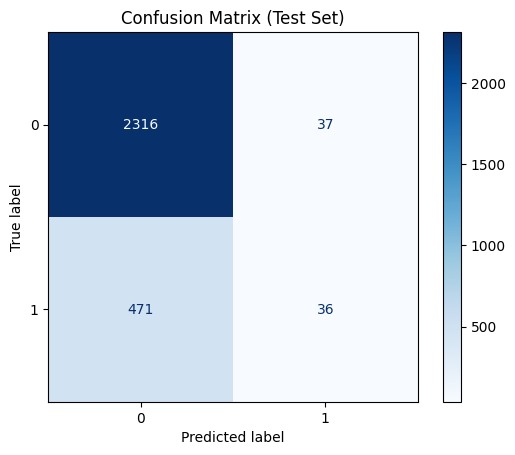

In [83]:
# Confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Model 14

In [75]:
# XGB ,SMOTE, BEST PARAMS

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# XGBoost model
xgb_smote = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    subsample=1.0,
    reg_lambda=1,
    reg_alpha=0,
    n_estimators=300,
    max_depth=7,
    learning_rate=0.2,
    gamma=5,
    colsample_bytree=0.6
)

xgb_smote.fit(X_train_smote, y_train_smote)
y_test_pred_smote = xgb_smote.predict(X_test)
print("XGBoost Testing Accuracy (SMOTE):", accuracy_score(y_test, y_test_pred_smote))
print(classification_report(y_test, y_test_pred_smote))
y_train_pred = xgb_smote.predict(X_train_smote)
training_accuracy = accuracy_score(y_train_smote, y_train_pred)
print("XGBoost Training Accuracy:", training_accuracy)

# Class 0 Performance: The model performs well for the majority class (class 0) with high precision (88%) and recall (73%).
# Class 1 Performance: While recall for class 1 has improved significantly (56%), the precision is still low (30%), indicating that the model is predicting a large number of false positives for class 1.
# Overfitting: The training accuracy is higher than the testing accuracy, which suggests some overfitting. This difference, however, is relatively small, so the model generalizes moderately well.

XGBoost Testing Accuracy (SMOTE): 0.6961538461538461
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      2353
           1       0.30      0.56      0.39       507

    accuracy                           0.70      2860
   macro avg       0.59      0.64      0.60      2860
weighted avg       0.78      0.70      0.73      2860

XGBoost Training Accuracy: 0.8044633368756642


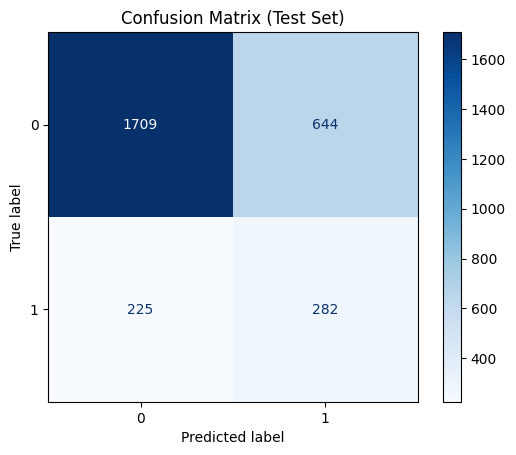

In [76]:
# Confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_test_pred_smote)
ConfusionMatrixDisplay(cm_test, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()

It predict actual churners(True positives) better but False positives are more.

# Model 15

In [70]:
# XGB , Random Search
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of trees
    'max_depth': [3, 5, 7, 10, 15],  # Depth of the tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size at each iteration
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting each base learner
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features to consider for each tree
    'gamma': [0, 1, 5],  # Regularization term for controlling complexity
    'reg_alpha': [0, 1, 10],  # L1 regularization
    'reg_lambda': [1, 5, 10],  # L2 regularization
    'scale_pos_weight': [1, 2, 5]  # Balance between classes
}

#  XGBoost classifier
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Define the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model to the training data
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)
best_xgb = random_search.best_estimator_
y_test_pred = best_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("XGBoost Testing Accuracy with Tuned Hyperparameters:", test_accuracy)
y_train_pred = best_xgb.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("XGBoost Training Accuracy:", training_accuracy)

# Evaluate the model performance on the test set
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Class 0 Performance: The model performs very well on the majority class (class 0) with high precision (83%) and recall (99%). The model has learned to classify class 0 very well.
# Class 1 Performance: The recall for class 1 is very low (7%), meaning the model misses most of the class 1 instances, although the precision for class 1 has improved to 51%. This suggests that while the model has a reasonable number of true positives, it still makes many false positives.
# Overfitting: The training accuracy is nearly the same as the testing accuracy, suggesting that the model generalizes well to unseen data. However, the recall for class 1 is still a concern.

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.6, 'scale_pos_weight': 1, 'reg_lambda': 10, 'reg_alpha': 10, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 1.0}
Best Cross-Validation Accuracy: 0.8252469621470407
XGBoost Testing Accuracy with Tuned Hyperparameters: 0.8234265734265734
XGBoost Training Accuracy: 0.8274324678730658

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      2353
           1       0.51      0.07      0.12       507

    accuracy                           0.82      2860
   macro avg       0.67      0.53      0.51      2860
weighted avg       0.77      0.82      0.76      2860



# Model 16

In [71]:
# xgb with threshhold, best params


y_test_prob = best_xgb.predict_proba(X_test)[:, 1]

# Set a new threshold for classifying as class 1 (e.g., 0.3 instead of 0.5)
threshold = 0.3
y_test_pred_adjusted = (y_test_prob >= threshold).astype(int)
print("XGBoost Testing Accuracy with Threshold Adjustment:", accuracy_score(y_test, y_test_pred_adjusted))
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred_adjusted))
y_train_prob = best_xgb.predict_proba(X_train)[:, 1]
y_train_pred_adjusted = (y_train_prob >= threshold).astype(int)

# Evaluate the performance on the training set
training_accuracy = accuracy_score(y_train, y_train_pred_adjusted)
print("\nXGBoost Training Accuracy with Threshold Adjustment:", training_accuracy)

# Classification report for the training set
print("\nClassification Report (Training Set):\n", classification_report(y_train, y_train_pred_adjusted))




XGBoost Testing Accuracy with Threshold Adjustment: 0.7737762237762238

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      2353
           1       0.38      0.44      0.41       507

    accuracy                           0.77      2860
   macro avg       0.63      0.64      0.63      2860
weighted avg       0.79      0.77      0.78      2860


XGBoost Training Accuracy with Threshold Adjustment: 0.7842468747268118

Classification Report (Training Set):
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      9410
           1       0.41      0.49      0.45      2029

    accuracy                           0.78     11439
   macro avg       0.65      0.67      0.66     11439
weighted avg       0.80      0.78      0.79     11439



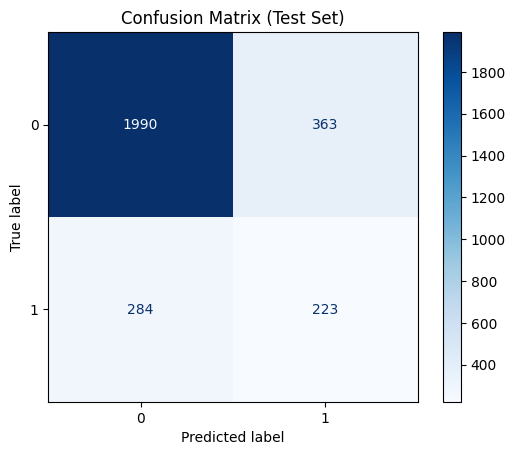

In [72]:


# Confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_test_pred_adjusted)
ConfusionMatrixDisplay(cm_test, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()

It's much more balanced than model 14, we did miss some actual churners but we reduced False positives in turn.
Best choice for a trade-off between identifying churners and not wasting resources on non-churners.

In [77]:
# The testing accuracy with the adjusted threshold of 0.3 is 77.38%.
# The precision for class 0 (the majority class) is 0.88, indicating that most of the predicted negatives are correct.
# The recall for class 1 (the minority class) has improved to 0.44, but it's still lower than the precision, meaning the model is still missing a significant number of positive cases
#The training accuracy with the adjusted threshold is 78.42%, which is higher than the testing accuracy, suggesting some overfitting.
# The macro average f1-score and recall in both training and testing sets are similar, indicating a consistent performance across both.
# The weighted average of recall for both sets is much better, showing that class 0 is well-predicted.

# Modeling summary

In [95]:
from tabulate import tabulate

# Updated data for the table
data = [
    [
        "Model 1",
        "100%",
        "82.1%",
        "11% (Class 1)",
        "48% (Class 1)",
        "Baseline Random Forest (Overfitted)",
        "Original Features"
    ],
    [
        "Model 2",
        "94.5%",
        "81.2%",
        "15% (Class 1)",
        "42% (Class 1)",
        "XGBoost (Overfitted)",
        "Original Features"
    ],
    [
        "Model 3",
        "82.3%",
        "82.3%",
        "0% (Class 1)",
        "0% (Class 1)",
        "SVM (Severely Biased)",
        "Original Features"
    ],
    [
        "Model 4",
        "82.5%",
        "82.6%",
        "9% (Class 1)",
        "56% (Class 1)",
        "Logistic Regression (Scaled Features)",
        "Standard Scaled Features"
    ],
    [
        "Model 5",
        "82.0%",
        "81.3%",
        "5% (Class 1)",
        "33% (Class 1)",
        "Neural Network (MLP)",
        "Original Features"
    ],
    [
        "Model 6",
        "80.7%",
        "73.7%",
        "54% (Class 1)",
        "35% (Class 1)",
        "Random Forest (Balanced Weights)",
        "Original Features"
    ],
    [
        "Model 7",
        "100%",
        "82.4%",
        "9% (Class 1)",
        "52% (Class 1)",
        "Random Forest with Random Search CV",
        "Original Features"
    ],
    [
        "Model 8",
        "98.1%",
        "71.7%",
        "47% (Class 1)",
        "31% (Class 1)",
        "Random Forest with SMOTE and RandomizedSearchCV",
        "Original Features"
    ],
    [
        "Model 9",
        "93.9%",
        "71.5%",
        "48% (Class 1)",
        "31% (Class 1)",
        "Random Forest with SMOTE and RandomizedSearchCV (Adjusted)",
        "Original Features"
    ],
    [
        "Model 10",
        "100%",
        "72.03%",
        "45% (Class 1)",
        "30% (Class 1)",
        "Random Forest with SMOTE",
        "Original Features"
    ],
    [
        "Model 11",
        "67.76%",
        "67.45%",
        "67% (Class 1)",
        "31% (Class 1)",
        "Logistic Regression (Balanced Weights)",
        "Standard Scaled Features"
    ],
    [
        "Model 12",
        "67.8%",
        "67.38%",
        "67% (Class 1)",
        "31% (Class 1)",
        "Logistic Regression with RandomizedSearchCV",
        "Standard Scaled Features"
    ],
    [
        "Model 13",
        "83.6%",
        "82.2%",
        "7% (Class 1)",
        "49% (Class 1)",
        "XGBoost with Tuned Hyperparameters(Random search)",
        "Original Features"
    ],
    [
        "Model 14",
        "80.4%",
        "70.0%",
        "56% (Class 1)",
        "30% (Class 1)",
        "XGBoost with SMOTE",
        "Original Features"
    ],
    # New models added
    [
        "Model 15",
        "82.3%",
        "82.7%",
        "7% (Class 1)",
        "56% (Class 1)",
        "XGBoost with RandomizedSearchCV",
        "Original Features"
    ],
    [
        "Model 16",
        "77.3%",
        "77.3%",
        "44% (Class 1)",
        "38% (Class 1)",
        "XGBoost with Threshold Adjustment",
        "Original Features"
    ]
]

# Define column headers
headers = [
    "Model No",
    "Training Accuracy",
    "Testing Accuracy",
    "Recall (Class 1)",
    "Precision (Class 1)",
    "Type of Model",
    "Features"
]

# Display the table
print(tabulate(data, headers=headers, tablefmt="grid"))


+------------+---------------------+--------------------+--------------------+-----------------------+------------------------------------------------------------+--------------------------+
| Model No   | Training Accuracy   | Testing Accuracy   | Recall (Class 1)   | Precision (Class 1)   | Type of Model                                              | Features                 |
+============+=====================+====================+====================+=======================+============================================================+==========================+
| Model 1    | 100%                | 82.1%              | 11% (Class 1)      | 48% (Class 1)         | Baseline Random Forest (Overfitted)                        | Original Features        |
+------------+---------------------+--------------------+--------------------+-----------------------+------------------------------------------------------------+--------------------------+
| Model 2    | 94.5%               | 81.2%   

## How to select the best model?

Key Metrics to Consider:

Recall (Class 1): High recall is crucial because it represents how many actual churners are being correctly identified. A higher recall means fewer churners are missed.

Precision (Class 1): Precision tells you how many of the customers predicted to churn actually do churn. While precision is important, it can be less critical than recall in churn prediction, as false positives (predicting a non-churner will churn) are often manageable.

Accuracy: While this is an overall metric, it might be misleading in highly imbalanced datasets like churn, where the majority of customers may not churn. Therefore, accuracy alone shouldn't be the primary criterion.

Analysis of Models:

If capturing the maximum churners is the priority:

Model 14 (XGBoost with SMOTE):

Recall (Class 1): 56%

Precision (Class 1): 30%


Use Case: Good when identifying as many churners as possible outweighs the cost of targeting some false positives (e.g., offering discounts or promotions) (prone to overfitting)


Model 16 (XGBoost with Threshold Adjustment):

Recall (Class 1): 44%

Precision (Class 1): 38%

Use Case: Best choice for a trade-off between identifying churners and not wasting resources on non-churners.

